In [1]:
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import h5py as h5

#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install ipython-autotime

#%load_ext autotime

In [3]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [4]:
class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [5]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers

In [6]:
tqdm = partial(tqdm, position=0, leave=True)

In [7]:
files_all=[]
for file in os.listdir("/content/drive/MyDrive/MAP-20210707T092105Z-001/MAP"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/MyDrive/MAP-20210707T092105Z-001/MAP/'

#centre_file = folder_path + files_all[50]
left_files_path_rev = []
right_files_path = []


#Change this according to your dataset split

for file in files_all[:61]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[60:120]:
  right_files_path.append(folder_path + file)

In [8]:
print(len(files_all))

176


In [9]:
from multiprocessing import Pool

In [10]:
import multiprocessing
print(multiprocessing.cpu_count())


2


In [11]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC )
  images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC )
  images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)

100%|██████████| 60/60 [02:10<00:00,  2.17s/it]


In [12]:
Dataset = 'MAP Dataset'

In [13]:
f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left_bgr + images_right_bgr)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_bgr_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 5.45571494102478 [s] ... size 887.702213 MB


In [ ]:
'''
f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left + images_right)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_gray_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 17.154690265655518 [s] ... size 1183.602268 MB


In [14]:
del images_left_bgr,images_right_bgr

In [ ]:
#images_left_bgr_no_enhance = []
#images_right_bgr_no_enhance = []

#for file in tqdm(left_files_path):
#  left_image_sat= cv2.imread(file)
#  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_left_bgr_no_enhance.append(left_img)

#for file in tqdm(right_files_path):
# right_image_sat= cv2.imread(file)
#  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_right_bgr_no_enhance.append(right_img)

In [15]:
from timeit import default_timer as timer

In [16]:
time_all = []

In [17]:
num_kps_sift = []
num_kps_brisk = []
num_kps_agast = []
num_kps_kaze = []
num_kps_akaze = []
num_kps_orb = []
num_kps_mser = []
num_kps_daisy = []
num_kps_surfsift = []
num_kps_fast = []
num_kps_freak = []
num_kps_gftt = []
num_kps_star = []
num_kps_surf = []
num_kps_rootsift = []
num_kps_superpoint = []


In [18]:
images_left_bgr=[]
images_right_bgr=[]

BRISK

In [ ]:
'''Threshl=60;
Octaves=6; 
#PatternScales=1.0f;

start = timer()

brisk = cv2.BRISK_create(Threshl,Octaves)


keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_left_brisk.append(kpt)
  descriptors_all_left_brisk.append(descrip)
  #points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_right_brisk.append(kpt)
  descriptors_all_right_brisk.append(descrip)
  #points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:24<00:00,  1.41s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_brisk + keypoints_all_right_brisk[1:]):
  num_kps_brisk.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 330911.56it/s]


In [ ]:
'''all_feat_brisk_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_brisk):
  all_feat_brisk_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_left_each.append(temp)
  all_feat_brisk_left.append(all_feat_brisk_left_each)

In [ ]:
'''all_feat_brisk_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_brisk):
  all_feat_brisk_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_right_each.append(temp)
  all_feat_brisk_right.append(all_feat_brisk_right_each)

In [ ]:
'''del keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk

In [ ]:
'''import pickle
Fdb = open('all_feat_brisk_left.dat', 'wb')
pickle.dump(all_feat_brisk_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_brisk_right.dat', 'wb')
pickle.dump(all_feat_brisk_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_brisk_left, all_feat_brisk_right

ORB

In [ ]:
'''orb = cv2.ORB_create(20000)

start = timer()


keypoints_all_left_orb = []
descriptors_all_left_orb = []
points_all_left_orb=[]

keypoints_all_right_orb = []
descriptors_all_right_orb = []
points_all_right_orb=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()    
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_left_orb.append(kpt)
  descriptors_all_left_orb.append(descrip)
  #points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_right_orb.append(kpt)
  descriptors_all_right_orb.append(descrip)
  #points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:17<00:00,  3.44it/s]


In [ ]:
'''for j in tqdm(keypoints_all_left_orb + keypoints_all_right_orb[1:]):
  num_kps_orb.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 66779.42it/s]


In [ ]:
'''all_feat_orb_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_orb):
  all_feat_orb_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_left_each.append(temp)
  all_feat_orb_left.append(all_feat_orb_left_each)

In [ ]:
'''all_feat_orb_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_orb):
  all_feat_orb_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_right_each.append(temp)
  all_feat_orb_right.append(all_feat_orb_right_each)

In [ ]:
'''del keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_left.dat', 'wb')
pickle.dump(all_feat_orb_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_orb_right.dat', 'wb')
pickle.dump(all_feat_orb_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_orb_left, all_feat_orb_right

KAZE


In [ ]:
'''start = timer()

kaze = cv2.KAZE_create()


keypoints_all_left_kaze = []
descriptors_all_left_kaze = []
points_all_left_kaze=[]

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []
points_all_right_kaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_left_kaze.append(kpt)
  descriptors_all_left_kaze.append(descrip)
  #points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_right_kaze.append(kpt)
  descriptors_all_right_kaze.append(descrip)
  #points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [07:19<00:00,  7.32s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_kaze + keypoints_all_right_kaze[1:]):
  num_kps_kaze.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 169924.54it/s]


In [ ]:
'''all_feat_kaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_kaze):
  all_feat_kaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_left_each.append(temp)
  all_feat_kaze_left.append(all_feat_kaze_left_each)

In [ ]:
'''all_feat_kaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_kaze):
  all_feat_kaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_right_each.append(temp)
  all_feat_kaze_right.append(all_feat_kaze_right_each)

In [ ]:
'''del keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_left.dat', 'wb')
pickle.dump(all_feat_kaze_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_kaze_right.dat', 'wb')
pickle.dump(all_feat_kaze_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_kaze_left, all_feat_kaze_right

AKAZE

In [ ]:
'''from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
'''start = timer()

akaze = cv2.AKAZE_create()


keypoints_all_left_akaze = []
descriptors_all_left_akaze = []
points_all_left_akaze=[]

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []
points_all_right_akaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_left_akaze.append(kpt)
  descriptors_all_left_akaze.append(descrip)
  #points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = akaze.detect(imgs,None)
  kpt,descrip = akaze.compute(imgs, kpt)
  keypoints_all_right_akaze.append(kpt)
  descriptors_all_right_akaze.append(descrip)
  #points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:28<00:00,  1.47s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_akaze + keypoints_all_right_akaze[1:]):
  num_kps_akaze.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 18709.95it/s]


In [ ]:
'''all_feat_akaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_akaze):
  all_feat_akaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_left_each.append(temp)
  all_feat_akaze_left.append(all_feat_akaze_left_each)

In [ ]:
'''all_feat_akaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_akaze):
  all_feat_akaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_right_each.append(temp)
  all_feat_akaze_right.append(all_feat_akaze_right_each)

In [ ]:
'''del keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_left.dat', 'wb')
pickle.dump(all_feat_akaze_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_akaze_right.dat', 'wb')
pickle.dump(all_feat_akaze_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_akaze_left, all_feat_akaze_right


STAR + BRIEF

In [ ]:
'''start = timer()

star = cv2.xfeatures2d.StarDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

keypoints_all_left_star = []
descriptors_all_left_brief = []
points_all_left_star=[]

keypoints_all_right_star = []
descriptors_all_right_brief = []
points_all_right_star=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_left_star.append(kpt)
  descriptors_all_left_brief.append(descrip)
  #points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_right_star.append(kpt)
  descriptors_all_right_brief.append(descrip)
  #points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [00:12<00:00,  5.00it/s]


In [ ]:
'''for j in tqdm(keypoints_all_left_star + keypoints_all_right_star[1:]):
  num_kps_star.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 252795.82it/s]


In [ ]:
'''all_feat_star_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_star):
  all_feat_star_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_left_each.append(temp)
  all_feat_star_left.append(all_feat_star_left_each)

In [ ]:
'''all_feat_star_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_star):
  all_feat_star_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_right_each.append(temp)
  all_feat_star_right.append(all_feat_star_right_each)

In [ ]:
'''del keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief

In [ ]:
'''import pickle
Fdb = open('all_feat_star_left.dat', 'wb')
pickle.dump(all_feat_star_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_star_right.dat', 'wb')
pickle.dump(all_feat_star_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_star_left, all_feat_star_right


BRISK + FREAK

In [19]:
start = timer()

Threshl=60;
Octaves=6; 
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)

freak = cv2.xfeatures2d.FREAK_create()
keypoints_all_left_freak = []
descriptors_all_left_freak = []
points_all_left_freak=[]

keypoints_all_right_freak = []
descriptors_all_right_freak = []
points_all_right_freak=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = brisk.detect(imgs)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_left_freak.append(kpt)
  descriptors_all_left_freak.append(descrip)
  #points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_right_freak.append(kpt)
  descriptors_all_right_freak.append(descrip)
  #points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:10<00:00,  1.17s/it]


In [20]:
for j in tqdm(keypoints_all_left_freak + keypoints_all_right_freak[1:]):
  num_kps_freak.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 40124.08it/s]


In [ ]:
'''
all_feat_freak_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_freak):
  all_feat_freak_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_left_each.append(temp)
  all_feat_freak_left.append(all_feat_freak_left_each)

In [ ]:
'''
all_feat_freak_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_freak):
  all_feat_freak_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_right_each.append(temp)
  all_feat_freak_right.append(all_feat_freak_right_each)

In [ ]:
'''
del keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak

In [ ]:
'''
import pickle
Fdb = open('all_feat_freak_left.dat', 'wb')
pickle.dump(all_feat_freak_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_freak_right.dat', 'wb')
pickle.dump(all_feat_freak_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_freak_left, all_feat_freak_right

MSER + SIFT

In [ ]:
'''
start = timer()

mser = cv2.MSER_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_mser = []
descriptors_all_left_mser = []
points_all_left_mser=[]

keypoints_all_right_mser = []
descriptors_all_right_mser = []
points_all_right_mser=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_mser.append(kpt)
  descriptors_all_left_mser.append(descrip)
  #points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_mser.append(kpt)
  descriptors_all_right_mser.append(descrip)
  #points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_mser + keypoints_all_right_mser[1:]):
  num_kps_mser.append(len(j))

In [ ]:
'''
all_feat_mser_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_mser):
  all_feat_mser_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_left_each.append(temp)
  all_feat_mser_left.append(all_feat_mser_left_each)

In [ ]:
'''
all_feat_mser_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_mser):
  all_feat_mser_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_right_each.append(temp)
  all_feat_mser_right.append(all_feat_mser_right_each)

In [ ]:
'''
del keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'wb')
pickle.dump(all_feat_mser_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'wb')
pickle.dump(all_feat_mser_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_mser_left, all_feat_mser_right

AGAST + SIFT

In [21]:

start = timer()

agast = cv2.AgastFeatureDetector_create(threshold = 60)
sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, contrastThreshold=0.02, edgeThreshold=4)

keypoints_all_left_agast = []
descriptors_all_left_agast = []
points_all_left_agast=[]

keypoints_all_right_agast = []
descriptors_all_right_agast = []
points_all_right_agast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_agast.append(kpt)
  descriptors_all_left_agast.append(descrip)
  #points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_agast.append(kpt)
  descriptors_all_right_agast.append(descrip)
  #points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [03:19<00:00,  3.32s/it]


In [22]:

for j in tqdm(keypoints_all_left_agast + keypoints_all_right_agast[1:]):
  num_kps_agast.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 95144.89it/s]


In [ ]:
'''
all_feat_agast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_agast):
  all_feat_agast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_left_each.append(temp)
  all_feat_agast_left.append(all_feat_agast_left_each)

In [ ]:
'''
all_feat_agast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_agast):
  all_feat_agast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_right_each.append(temp)
  all_feat_agast_right.append(all_feat_agast_right_each)

In [ ]:
'''
del keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_left.dat', 'wb')
pickle.dump(all_feat_agast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_agast_left

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_right.dat', 'wb')
pickle.dump(all_feat_agast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_agast_right

FAST + SIFT

In [23]:

start = timer()


fast = cv2.FastFeatureDetector_create(threshold=60)
sift = cv2.xfeatures2d.SIFT_create(nfeatures = 1000, contrastThreshold=0.02, edgeThreshold=4)

keypoints_all_left_fast = []
descriptors_all_left_fast = []
points_all_left_fast=[]

keypoints_all_right_fast = []
descriptors_all_right_fast = []
points_all_right_fast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_fast.append(kpt)
  descriptors_all_left_fast.append(descrip)
  #points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_fast.append(kpt)
  descriptors_all_right_fast.append(descrip)
  #points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [03:00<00:00,  3.01s/it]


In [24]:

for j in tqdm(keypoints_all_left_fast + keypoints_all_right_fast[1:]):
  num_kps_fast.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 109155.60it/s]


In [ ]:
'''
all_feat_fast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_fast):
  all_feat_fast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_left_each.append(temp)
  all_feat_fast_left.append(all_feat_fast_left_each)

In [ ]:
'''
all_feat_fast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_fast):
  all_feat_fast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_right_each.append(temp)
  all_feat_fast_right.append(all_feat_fast_right_each)

In [ ]:
'''
del keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'wb')
pickle.dump(all_feat_fast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'wb')
pickle.dump(all_feat_fast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_fast_left, all_feat_fast_right

GFTT + SIFT

In [ ]:
'''
start = timer()

gftt = cv2.GFTTDetector_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []
points_all_left_gftt=[]

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []
points_all_right_gftt=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_gftt.append(kpt)
  descriptors_all_left_gftt.append(descrip)
  #points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_gftt.append(kpt)
  descriptors_all_right_gftt.append(descrip)
  #points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_gftt + keypoints_all_right_gftt[1:]):
  num_kps_gftt.append(len(j))

In [ ]:
'''
all_feat_gftt_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_gftt):
  all_feat_gftt_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_left_each.append(temp)
  all_feat_gftt_left.append(all_feat_gftt_left_each)

In [ ]:
'''
all_feat_gftt_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_gftt):
  all_feat_gftt_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_right_each.append(temp)
  all_feat_gftt_right.append(all_feat_gftt_right_each)

In [ ]:
'''
del keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'wb')
pickle.dump(all_feat_gftt_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'wb')
pickle.dump(all_feat_gftt_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_gftt_left, all_feat_gftt_right

DAISY+SIFT

In [ ]:
'''
start = timer()

daisy = cv2.xfeatures2d.DAISY_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []
points_all_left_daisy=[]

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []
points_all_right_daisy=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_left_daisy.append(kpt)
  descriptors_all_left_daisy.append(descrip)
  #points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_right_daisy.append(kpt)
  descriptors_all_right_daisy.append(descrip)
  #points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_daisy + keypoints_all_right_daisy[1:]):
  num_kps_daisy.append(len(j))

In [ ]:
'''
all_feat_daisy_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_daisy):
  all_feat_daisy_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_left_each.append(temp)
  all_feat_daisy_left.append(all_feat_daisy_left_each)

In [ ]:
'''
all_feat_daisy_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_daisy):
  all_feat_daisy_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_right_each.append(temp)
  all_feat_daisy_right.append(all_feat_daisy_right_each)

In [ ]:
'''
del keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'wb')
pickle.dump(all_feat_daisy_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'wb')
pickle.dump(all_feat_daisy_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_daisy_left, all_feat_daisy_right

SURF + SIFT

In [ ]:
'''
start = timer()

surf = cv2.xfeatures2d.SURF_create(upright=1)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []
points_all_left_surfsift=[]

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []
points_all_right_surfsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_surfsift.append(kpt)
  descriptors_all_left_surfsift.append(descrip)
  #points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_surfsift.append(kpt)
  descriptors_all_right_surfsift.append(descrip)
  #points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_surfsift + keypoints_all_right_surfsift[1:]):
  num_kps_surfsift.append(len(j))

In [ ]:
'''
all_feat_surfsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surfsift):
  all_feat_surfsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_left_each.append(temp)
  all_feat_surfsift_left.append(all_feat_surfsift_left_each)

In [ ]:
'''
all_feat_surfsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surfsift):
  all_feat_surfsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_right_each.append(temp)
  all_feat_surfsift_right.append(all_feat_surfsift_right_each)

In [ ]:
'''
del keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'wb')
pickle.dump(all_feat_surfsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'wb')
pickle.dump(all_feat_surfsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surfsift_left, all_feat_surfsift_right

SIFT

In [25]:

print(len(left_files_path))

61


In [26]:

print(len(right_files_path))

60


In [ ]:
# H5 file w/o compression
#t0=time.time()
#f=h5.File('drive/MyDrive/all_images_bgr_sift.h5','r')
#print('HDF5  w/o comp.: data shape =',len(f['data'][0]),time.time()-t0,'[s]')
#f.close()

In [ ]:
#del f

In [27]:

start = timer()

sift = cv2.xfeatures2d.SIFT_create(nfeatures = 2000, contrastThreshold=0.02, edgeThreshold=6 )
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_sift.append(kpt)
  descriptors_all_left_sift.append(descrip)
  #points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_sift.append(kpt)
  descriptors_all_right_sift.append(descrip)
  #points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [01:33<00:00,  1.56s/it]


In [28]:

for j in tqdm(keypoints_all_left_sift + keypoints_all_right_sift[1:]):
  num_kps_sift.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 157090.04it/s]


In [ ]:
'''
all_feat_sift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_sift):
  all_feat_sift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_left_each.append(temp)
  all_feat_sift_left.append(all_feat_sift_left_each)

In [ ]:
'''
all_feat_sift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_sift):
  all_feat_sift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_right_each.append(temp)
  all_feat_sift_right.append(all_feat_sift_right_each)

In [ ]:
'''
del keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'wb')
pickle.dump(all_feat_sift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'wb')
pickle.dump(all_feat_sift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_sift_left, all_feat_sift_right

In [ ]:
#del keypoints_all_right_sift, keypoints_all_left_sift, descriptors_all_right_sift, descriptors_all_left_sift, points_all_right_sift, points_all_left_sift

SURF

In [29]:

start = timer()

surf  = cv2.xfeatures2d.SURF_create(nOctaves = 3, hessianThreshold = 60 ,upright=1)
keypoints_all_left_surf = []
descriptors_all_left_surf = []
points_all_left_surf=[]

keypoints_all_right_surf = []
descriptors_all_right_surf = []
points_all_right_surf=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_left_surf.append(kpt)
  descriptors_all_left_surf.append(descrip)
  #points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_right_surf.append(kpt)
  descriptors_all_right_surf.append(descrip)
  #points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:17<00:00,  2.29s/it]


In [30]:

for j in tqdm(keypoints_all_left_surf + keypoints_all_right_surf[1:]):
  num_kps_surf.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 286953.52it/s]


In [ ]:
'''
all_feat_surf_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surf):
  all_feat_surf_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_left_each.append(temp)
  all_feat_surf_left.append(all_feat_surf_left_each)

In [ ]:
'''
all_feat_surf_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surf):
  all_feat_surf_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_right_each.append(temp)
  all_feat_surf_right.append(all_feat_surf_right_each)

In [ ]:
'''
del keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'wb')
pickle.dump(all_feat_surf_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'wb')
pickle.dump(all_feat_surf_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surf_left, all_feat_surf_right

ROOTSIFT

In [ ]:
'''class RootSIFT:
  def __init__(self):
    # initialize the SIFT feature extractor
    #self.extractor = cv2.DescriptorExtractor_create("SIFT")
    self.sift = cv2.xfeatures2d.SIFT_create()

  def compute(self, image, kps, eps=1e-7):
    # compute SIFT descriptors
    (kps, descs) = self.sift.compute(image, kps)

    # if there are no keypoints or descriptors, return an empty tuple
    if len(kps) == 0:
      return ([], None)

    # apply the Hellinger kernel by first L1-normalizing, taking the
    # square-root, and then L2-normalizing
    descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)
    descs /= (descs.sum(axis=0) + eps)
    descs = np.sqrt(descs)
    #descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)

    # return a tuple of the keypoints and descriptors
    return (kps, descs)

In [ ]:
'''start = timer()

sift = cv2.xfeatures2d.SIFT_create()
rootsift = RootSIFT()
keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []
points_all_left_rootsift=[]

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []
points_all_right_rootsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_left_rootsift.append(kpt)
  descriptors_all_left_rootsift.append(descrip)
  #points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_right_rootsift.append(kpt)
  descriptors_all_right_rootsift.append(descrip)
  #points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 60/60 [02:57<00:00,  2.95s/it]


In [ ]:
'''for j in tqdm(keypoints_all_left_rootsift + keypoints_all_right_rootsift[1:]):
  num_kps_rootsift.append(len(j))

100%|██████████| 120/120 [00:00<00:00, 48989.34it/s]


In [ ]:
'''all_feat_rootsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_rootsift):
  all_feat_rootsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_left_each.append(temp)
  all_feat_rootsift_left.append(all_feat_rootsift_left_each)

In [ ]:
'''all_feat_rootsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_rootsift):
  all_feat_rootsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_right_each.append(temp)
  all_feat_rootsift_right.append(all_feat_rootsift_right_each)

In [ ]:
'''del keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_left.dat', 'wb')
pickle.dump(all_feat_rootsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''import pickle
Fdb = open('all_feat_rootsift_right.dat', 'wb')
pickle.dump(all_feat_rootsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''del Fdb, all_feat_rootsift_left, all_feat_rootsift_right

SuperPoint

In [ ]:
'''
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

In [ ]:
'''
weights_path = 'SuperPointPretrainedNetwork/superpoint_v1.pth'

cuda = 'True'

In [ ]:
'''
def to_kpts(pts, size=1):
  return [cv2.KeyPoint(pt[0], pt[1], size) for pt in pts]

In [ ]:
'''
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.cuda.empty_cache()

class SuperPointNet(nn.Module):
    def __init__(self):
        super(SuperPointNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        # Shared Encoder.
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        # Detector Head.
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        # Descriptor Head.
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
        desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
        return semi, desc


class SuperPointFrontend(object):
    def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh,cuda=True):
        self.name = 'SuperPoint'
        self.cuda = cuda
        self.nms_dist = nms_dist
        self.conf_thresh = conf_thresh
        self.nn_thresh = nn_thresh # L2 descriptor distance for good match.
        self.cell = 8 # Size of each output cell. Keep this fixed.
        self.border_remove = 4 # Remove points this close to the border.

        # Load the network in inference mode.
        self.net = SuperPointNet()
        if cuda:
          # Train on GPU, deploy on GPU.
            self.net.load_state_dict(torch.load(weights_path))
            self.net = self.net.cuda()
        else:
          # Train on GPU, deploy on CPU.
            self.net.load_state_dict(torch.load(weights_path, map_location=lambda storage, loc: storage))
        self.net.eval()

    def nms_fast(self, in_corners, H, W, dist_thresh):

        grid = np.zeros((H, W)).astype(int) # Track NMS data.
        inds = np.zeros((H, W)).astype(int) # Store indices of points.
        # Sort by confidence and round to nearest int.
        inds1 = np.argsort(-in_corners[2,:])
        corners = in_corners[:,inds1]
        rcorners = corners[:2,:].round().astype(int) # Rounded corners.
        # Check for edge case of 0 or 1 corners.
        if rcorners.shape[1] == 0:
            return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
        if rcorners.shape[1] == 1:
            out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
            return out, np.zeros((1)).astype(int)
        # Initialize the grid.
        for i, rc in enumerate(rcorners.T):
            grid[rcorners[1,i], rcorners[0,i]] = 1
            inds[rcorners[1,i], rcorners[0,i]] = i
        # Pad the border of the grid, so that we can NMS points near the border.
        pad = dist_thresh
        grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
        # Iterate through points, highest to lowest conf, suppress neighborhood.
        count = 0
        for i, rc in enumerate(rcorners.T):
          # Account for top and left padding.
            pt = (rc[0]+pad, rc[1]+pad)
            if grid[pt[1], pt[0]] == 1: # If not yet suppressed.
                grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
                grid[pt[1], pt[0]] = -1
                count += 1
        # Get all surviving -1's and return sorted array of remaining corners.
        keepy, keepx = np.where(grid==-1)
        keepy, keepx = keepy - pad, keepx - pad
        inds_keep = inds[keepy, keepx]
        out = corners[:, inds_keep]
        values = out[-1, :]
        inds2 = np.argsort(-values)
        out = out[:, inds2]
        out_inds = inds1[inds_keep[inds2]]
        return out, out_inds

    def run(self, img):
        assert img.ndim == 2 #Image must be grayscale.
        assert img.dtype == np.float32 #Image must be float32.
        H, W = img.shape[0], img.shape[1]
        inp = img.copy()
        inp = (inp.reshape(1, H, W))
        inp = torch.from_numpy(inp)
        inp = torch.autograd.Variable(inp).view(1, 1, H, W)
        if self.cuda:
            inp = inp.cuda()
        # Forward pass of network.
        outs = self.net.forward(inp)
        semi, coarse_desc = outs[0], outs[1]
        # Convert pytorch -> numpy.
        semi = semi.data.cpu().numpy().squeeze()
        
        # --- Process points.
        dense = np.exp(semi) # Softmax.
        dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
        nodust = dense[:-1, :, :]
        # Reshape to get full resolution heatmap.
        Hc = int(H / self.cell)
        Wc = int(W / self.cell)
        nodust = np.transpose(nodust, [1, 2, 0])
        heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
        heatmap = np.transpose(heatmap, [0, 2, 1, 3])
        heatmap = np.reshape(heatmap, [Hc*self.cell, Wc*self.cell]) 
        prob_map = heatmap/np.sum(np.sum(heatmap))
        
        return heatmap, coarse_desc


    def key_pt_sampling(self, img, heat_map, coarse_desc, sampled):
        
        H, W = img.shape[0], img.shape[1]

        xs, ys = np.where(heat_map >= self.conf_thresh) # Confidence threshold.
        if len(xs) == 0:
            return np.zeros((3, 0)), None, None
        print("number of pts selected :", len(xs))
        
        
        pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
        pts[0, :] = ys
        pts[1, :] = xs
        pts[2, :] = heat_map[xs, ys]
        pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist) # Apply NMS.
        inds = np.argsort(pts[2,:])
        pts = pts[:,inds[::-1]] # Sort by confidence.
        bord = self.border_remove
        toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
        toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
        toremove = np.logical_or(toremoveW, toremoveH)
        pts = pts[:, ~toremove]
        pts = pts[:,0:sampled] #we take 2000 keypoints with highest probability from heatmap for our benchmark
        
        # --- Process descriptor.
        D = coarse_desc.shape[1]
        if pts.shape[1] == 0:
            desc = np.zeros((D, 0))
        else:
          # Interpolate into descriptor map using 2D point locations.
            samp_pts = torch.from_numpy(pts[:2, :].copy())
            samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
            samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
            samp_pts = samp_pts.transpose(0, 1).contiguous()
            samp_pts = samp_pts.view(1, 1, -1, 2)
            samp_pts = samp_pts.float()
            if self.cuda:
                samp_pts = samp_pts.cuda()            
            desc = nn.functional.grid_sample(coarse_desc, samp_pts)
            desc = desc.data.cpu().numpy().reshape(D, -1)
            desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]

            
        return pts, desc

In [ ]:
'''
print('Loading pre-trained network.')
# This class runs the SuperPoint network and processes its outputs.
fe = SuperPointFrontend(weights_path=weights_path,nms_dist = 3,conf_thresh = 0.01,nn_thresh=0.5)
print('Successfully loaded pre-trained network.')

In [ ]:
'''
start = timer()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []
points_all_left_superpoint=[]

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []
points_all_right_superpoint=[]

tqdm = partial(tqdm, position=0, leave=True)

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  lfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(lfpth)
  pts_1, desc_1 = fe.key_pt_sampling(lfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_left_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_left_superpoint.append(desc_1.T)
  #points_all_left_superpoint.append(pts_1.T)


for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  rfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(rfpth)
  pts_1, desc_1 = fe.key_pt_sampling(rfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_right_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_right_superpoint.append(desc_1.T)
  #points_all_right_superpoint.append(pts_1.T)

end = timer()
time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_superpoint + keypoints_all_right_superpoint[1:]):
  num_kps_superpoint.append(len(j))

In [ ]:
'''
all_feat_superpoint_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_superpoint):
  all_feat_superpoint_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_left_each.append(temp)
  all_feat_superpoint_left.append(all_feat_superpoint_left_each)

In [ ]:
'''
all_feat_superpoint_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_superpoint):
  all_feat_superpoint_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_right_each.append(temp)
  all_feat_superpoint_right.append(all_feat_superpoint_right_each)

In [ ]:
'''
del keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'wb')
pickle.dump(all_feat_superpoint_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'wb')
pickle.dump(all_feat_superpoint_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_superpoint_left, all_feat_superpoint_right

Total Matches,Robust Matches and Homography Computation

In [31]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh, maxIters=3000)
    inliers = inliers.flatten()
    return H, inliers

In [32]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [33]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.75,thresh=4,use_lowe=True,disp=False,no_ransac=False,binary=False):
  lff1 = descripts[0]
  lff = descripts[1]

  if use_lowe==False:
    #FLANN_INDEX_KDTREE = 2
    #index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    #search_params = dict(checks=50)
    #flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.BFMatcher()
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    #matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    matches_4 = bf.knnMatch(lff1, lff,k=2)
    matches_lf1_lf = []


    print("\nNumber of matches",len(matches_4))
    '''
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      #if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
      matches_4.append(m[0])
    '''
    print("Number of matches After Lowe's Ratio",len(matches_4))
  else:
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])
    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    #matches_lf1_lf = bf.knnMatch(lff1, lff,k=2)


    print("\nNumber of matches",len(matches_lf1_lf))
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])
  
    print("Number of matches After Lowe's Ratio",len(matches_4))


  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  if no_ransac==True:
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)
  else:
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  

  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  
  if len(inlier_matchset)<25:
    matches_4 = []
    ratio = 0.85
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
  
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [34]:
def get_Hmatrix_rfnet(imgs,pts,descripts,disp=True):

  des1 = descripts[0]
  des2 = descripts[1]

  kp1 = pts[0]
  kp2 = pts[1]


  predict_label, nn_kp2 = nearest_neighbor_distance_ratio_match(des1, des2, kp2, 0.7)
  idx = predict_label.nonzero().view(-1)
  mkp1 = kp1.index_select(dim=0, index=idx.long())  # predict match keypoints in I1
  mkp2 = nn_kp2.index_select(dim=0, index=idx.long())  # predict match keypoints in I2

  #img1, img2 = reverse_img(img1), reverse_img(img2)
  keypoints1 = list(map(to_cv2_kp, mkp1))
  keypoints2 = list(map(to_cv2_kp, mkp2))
  DMatch = list(map(to_cv2_dmatch, np.arange(0, len(keypoints1))))

  imm1_pts=np.empty((len(DMatch),2))
  imm2_pts=np.empty((len(DMatch),2))
  for i in range(0,len(DMatch)):
    m = DMatch[i]
    (a_x, a_y) = keypoints1[m.queryIdx].pt
    (b_x, b_y) = keypoints2[m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography_fast(imm1_pts,imm2_pts) 


  if disp==True:
    dispimg1 = cv2.drawMatches(imgs[0], keypoints1, imgs[1], keypoints2, DMatch, None)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')


  return H/H[2,2]

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_brisk.append(keypoints_each)
  descriptors_all_left_brisk.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_brisk.append(keypoints_each)
  descriptors_all_right_brisk.append(descrip_each)

In [ ]:
'''
H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

images_left_bgr = []
images_right_bgr = []
for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_left_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_right_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.020707368850708008 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.00494694709777832 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_brisk, H_right_brisk,keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk, points_all_left_brisk, points_all_right_brisk

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_sift = []
descriptors_all_left_sift = []



for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_sift.append(keypoints_each)
  descriptors_all_left_sift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_sift = []
descriptors_all_right_sift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_sift.append(keypoints_each)
  descriptors_all_right_sift.append(descrip_each)

In [35]:

H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1],0.75)
  H_left_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1],0.75)
  H_right_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

  2%|▏         | 1/61 [00:00<00:18,  3.32it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 235
Number of Robust matches 179




  3%|▎         | 2/61 [00:00<00:17,  3.45it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 199
Number of Robust matches 158




  5%|▍         | 3/61 [00:00<00:16,  3.61it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 197
Number of Robust matches 123




  7%|▋         | 4/61 [00:01<00:15,  3.63it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 158
Number of Robust matches 75




  8%|▊         | 5/61 [00:01<00:17,  3.13it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 12
Number of Robust matches 10


Number of matches After Lowe's Ratio New 73
Number of Robust matches New 12




 10%|▉         | 6/61 [00:01<00:16,  3.34it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 424
Number of Robust matches 321




 11%|█▏        | 7/61 [00:02<00:15,  3.51it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 274
Number of Robust matches 242




 13%|█▎        | 8/61 [00:02<00:15,  3.50it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 376
Number of Robust matches 342




 15%|█▍        | 9/61 [00:02<00:14,  3.58it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 442
Number of Robust matches 388




 16%|█▋        | 10/61 [00:02<00:13,  3.68it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 433
Number of Robust matches 421




 18%|█▊        | 11/61 [00:03<00:13,  3.69it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 463
Number of Robust matches 438




 20%|█▉        | 12/61 [00:03<00:13,  3.70it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 496
Number of Robust matches 460




 21%|██▏       | 13/61 [00:03<00:12,  3.70it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 492
Number of Robust matches 420




 23%|██▎       | 14/61 [00:03<00:12,  3.76it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 458
Number of Robust matches 450




 25%|██▍       | 15/61 [00:04<00:12,  3.77it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 460
Number of Robust matches 442




 26%|██▌       | 16/61 [00:04<00:12,  3.66it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 439
Number of Robust matches 422




 28%|██▊       | 17/61 [00:04<00:11,  3.71it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 362
Number of Robust matches 330




 30%|██▉       | 18/61 [00:04<00:11,  3.75it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 370
Number of Robust matches 364




 31%|███       | 19/61 [00:05<00:11,  3.74it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 434
Number of Robust matches 374




 33%|███▎      | 20/61 [00:05<00:10,  3.75it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 480
Number of Robust matches 466




 34%|███▍      | 21/61 [00:05<00:10,  3.72it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 481
Number of Robust matches 457




 36%|███▌      | 22/61 [00:06<00:10,  3.77it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 456
Number of Robust matches 433




 38%|███▊      | 23/61 [00:06<00:10,  3.79it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 374
Number of Robust matches 349




 39%|███▉      | 24/61 [00:06<00:09,  3.93it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 387
Number of Robust matches 365




 41%|████      | 25/61 [00:06<00:09,  3.84it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 24
Number of Robust matches 22


Number of matches After Lowe's Ratio New 85
Number of Robust matches New 30




 43%|████▎     | 26/61 [00:07<00:09,  3.88it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 737
Number of Robust matches 731




 44%|████▍     | 27/61 [00:07<00:08,  3.82it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 447
Number of Robust matches 422




 46%|████▌     | 28/61 [00:07<00:08,  3.81it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 498
Number of Robust matches 478




 48%|████▊     | 29/61 [00:07<00:08,  3.82it/s]


Number of matches 2002
Number of matches After Lowe's Ratio 481
Number of Robust matches 474




 49%|████▉     | 30/61 [00:08<00:08,  3.81it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 479
Number of Robust matches 438




 51%|█████     | 31/61 [00:08<00:07,  3.76it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 481
Number of Robust matches 473




 52%|█████▏    | 32/61 [00:08<00:07,  3.70it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 425
Number of Robust matches 421




 54%|█████▍    | 33/61 [00:08<00:07,  3.69it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 473
Number of Robust matches 451




 56%|█████▌    | 34/61 [00:09<00:07,  3.72it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 495
Number of Robust matches 480




 57%|█████▋    | 35/61 [00:09<00:07,  3.66it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 567
Number of Robust matches 475




 59%|█████▉    | 36/61 [00:09<00:06,  3.67it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 576
Number of Robust matches 540




 61%|██████    | 37/61 [00:10<00:06,  3.65it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 639
Number of Robust matches 601




 62%|██████▏   | 38/61 [00:10<00:06,  3.59it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 611
Number of Robust matches 607




 64%|██████▍   | 39/61 [00:10<00:05,  3.71it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 548
Number of Robust matches 539




 66%|██████▌   | 40/61 [00:10<00:05,  3.78it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 555
Number of Robust matches 542




 67%|██████▋   | 41/61 [00:11<00:05,  3.75it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 26
Number of Robust matches 21


Number of matches After Lowe's Ratio New 90
Number of Robust matches New 36




 69%|██████▉   | 42/61 [00:11<00:05,  3.68it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 748
Number of Robust matches 746




 70%|███████   | 43/61 [00:11<00:04,  3.67it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 536
Number of Robust matches 534




 72%|███████▏  | 44/61 [00:11<00:04,  3.68it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 481
Number of Robust matches 479




 74%|███████▍  | 45/61 [00:12<00:04,  3.71it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 465
Number of Robust matches 433




 75%|███████▌  | 46/61 [00:12<00:04,  3.69it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 396
Number of Robust matches 389




 77%|███████▋  | 47/61 [00:12<00:03,  3.76it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 419
Number of Robust matches 411




 79%|███████▊  | 48/61 [00:12<00:03,  3.78it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 427
Number of Robust matches 425




 80%|████████  | 49/61 [00:13<00:03,  3.83it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 345
Number of Robust matches 342




 82%|████████▏ | 50/61 [00:13<00:02,  3.75it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 371
Number of Robust matches 335




 84%|████████▎ | 51/61 [00:13<00:02,  3.75it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 351
Number of Robust matches 341




 85%|████████▌ | 52/61 [00:14<00:03,  2.41it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 61
Number of Robust matches 47




 87%|████████▋ | 53/61 [00:14<00:02,  2.70it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 685
Number of Robust matches 679




 89%|████████▊ | 54/61 [00:15<00:02,  2.92it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 396
Number of Robust matches 368




 90%|█████████ | 55/61 [00:15<00:01,  3.12it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 446
Number of Robust matches 436




 92%|█████████▏| 56/61 [00:15<00:01,  3.26it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 452
Number of Robust matches 448




 93%|█████████▎| 57/61 [00:15<00:01,  3.39it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 515
Number of Robust matches 507




 95%|█████████▌| 58/61 [00:16<00:00,  3.52it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 504
Number of Robust matches 496




 97%|█████████▋| 59/61 [00:16<00:00,  3.63it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 112
Number of Robust matches 102




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 633
Number of Robust matches 615




  2%|▏         | 1/60 [00:00<00:15,  3.74it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 284
Number of Robust matches 231




  3%|▎         | 2/60 [00:00<00:15,  3.69it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 311
Number of Robust matches 284




  5%|▌         | 3/60 [00:00<00:15,  3.66it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 311
Number of Robust matches 271




  7%|▋         | 4/60 [00:01<00:15,  3.65it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 375
Number of Robust matches 352




  8%|▊         | 5/60 [00:01<00:15,  3.64it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 402
Number of Robust matches 364




 10%|█         | 6/60 [00:01<00:14,  3.62it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 383
Number of Robust matches 332




 12%|█▏        | 7/60 [00:01<00:14,  3.66it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 388
Number of Robust matches 385




 13%|█▎        | 8/60 [00:02<00:13,  3.72it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 354
Number of Robust matches 317




 15%|█▌        | 9/60 [00:02<00:13,  3.73it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 341
Number of Robust matches 309




 17%|█▋        | 10/60 [00:02<00:13,  3.71it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 365
Number of Robust matches 355




 18%|█▊        | 11/60 [00:02<00:13,  3.70it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 417
Number of Robust matches 405




 20%|██        | 12/60 [00:03<00:13,  3.63it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 415
Number of Robust matches 405




 22%|██▏       | 13/60 [00:03<00:12,  3.64it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 471
Number of Robust matches 463




 23%|██▎       | 14/60 [00:03<00:12,  3.64it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 484
Number of Robust matches 458




 25%|██▌       | 15/60 [00:04<00:12,  3.66it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 511
Number of Robust matches 476




 27%|██▋       | 16/60 [00:04<00:12,  3.59it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 513
Number of Robust matches 472




 28%|██▊       | 17/60 [00:04<00:11,  3.65it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 478
Number of Robust matches 404




 30%|███       | 18/60 [00:04<00:11,  3.72it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 401
Number of Robust matches 327




 32%|███▏      | 19/60 [00:05<00:11,  3.68it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 467
Number of Robust matches 425




 33%|███▎      | 20/60 [00:05<00:10,  3.70it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 716
Number of Robust matches 713




 35%|███▌      | 21/60 [00:05<00:10,  3.69it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 76
Number of Robust matches 71




 37%|███▋      | 22/60 [00:05<00:10,  3.70it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 591
Number of Robust matches 587




 38%|███▊      | 23/60 [00:06<00:09,  3.70it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 624
Number of Robust matches 528




 40%|████      | 24/60 [00:06<00:09,  3.71it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 565
Number of Robust matches 560




 42%|████▏     | 25/60 [00:06<00:09,  3.72it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 490
Number of Robust matches 464




 43%|████▎     | 26/60 [00:07<00:09,  3.67it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 474
Number of Robust matches 453




 45%|████▌     | 27/60 [00:07<00:08,  3.70it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 452
Number of Robust matches 437




 47%|████▋     | 28/60 [00:07<00:08,  3.74it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 442
Number of Robust matches 413




 48%|████▊     | 29/60 [00:07<00:08,  3.65it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 514
Number of Robust matches 509




 50%|█████     | 30/60 [00:08<00:08,  3.64it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 486
Number of Robust matches 484




 52%|█████▏    | 31/60 [00:08<00:07,  3.67it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 444
Number of Robust matches 401




 53%|█████▎    | 32/60 [00:08<00:07,  3.77it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 481
Number of Robust matches 463




 55%|█████▌    | 33/60 [00:08<00:07,  3.79it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 434
Number of Robust matches 416




 57%|█████▋    | 34/60 [00:09<00:06,  3.75it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 368
Number of Robust matches 289




 58%|█████▊    | 35/60 [00:09<00:06,  3.74it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 356
Number of Robust matches 340




 60%|██████    | 36/60 [00:09<00:06,  3.76it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 412
Number of Robust matches 389




 62%|██████▏   | 37/60 [00:10<00:06,  3.78it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 390
Number of Robust matches 360




 63%|██████▎   | 38/60 [00:10<00:05,  3.72it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 412
Number of Robust matches 323




 65%|██████▌   | 39/60 [00:10<00:05,  3.72it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 386
Number of Robust matches 346




 67%|██████▋   | 40/60 [00:10<00:05,  3.71it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 272
Number of Robust matches 240




 68%|██████▊   | 41/60 [00:11<00:05,  3.67it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 203
Number of Robust matches 172




 70%|███████   | 42/60 [00:11<00:04,  3.74it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 228
Number of Robust matches 172




 72%|███████▏  | 43/60 [00:11<00:04,  3.76it/s]


Number of matches 2002
Number of matches After Lowe's Ratio 207
Number of Robust matches 133




 73%|███████▎  | 44/60 [00:11<00:04,  3.71it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 215
Number of Robust matches 114




 75%|███████▌  | 45/60 [00:12<00:04,  3.67it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 201
Number of Robust matches 85




 77%|███████▋  | 46/60 [00:12<00:03,  3.67it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 190
Number of Robust matches 69




 78%|███████▊  | 47/60 [00:12<00:03,  3.73it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 201
Number of Robust matches 88




 80%|████████  | 48/60 [00:12<00:03,  3.76it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 245
Number of Robust matches 119




 82%|████████▏ | 49/60 [00:13<00:02,  3.78it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 409
Number of Robust matches 255




 83%|████████▎ | 50/60 [00:13<00:02,  3.52it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 21
Number of Robust matches 12


Number of matches After Lowe's Ratio New 96
Number of Robust matches New 12




 85%|████████▌ | 51/60 [00:13<00:02,  3.56it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 148
Number of Robust matches 101




 87%|████████▋ | 52/60 [00:14<00:02,  3.60it/s]


Number of matches 2001
Number of matches After Lowe's Ratio 194
Number of Robust matches 107




 88%|████████▊ | 53/60 [00:14<00:01,  3.65it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 175
Number of Robust matches 81




 90%|█████████ | 54/60 [00:14<00:01,  3.69it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 194
Number of Robust matches 77




 92%|█████████▏| 55/60 [00:14<00:01,  3.68it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 204
Number of Robust matches 78




 93%|█████████▎| 56/60 [00:15<00:01,  3.61it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 240
Number of Robust matches 107




 95%|█████████▌| 57/60 [00:15<00:00,  3.63it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 243
Number of Robust matches 112




 97%|█████████▋| 58/60 [00:15<00:00,  3.61it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 198
Number of Robust matches 121




 98%|█████████▊| 59/60 [00:16<00:00,  3.60it/s]


Number of matches 2000
Number of matches After Lowe's Ratio 196
Number of Robust matches 120




In [36]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005560398101806641 [s] ... size 0.006368 MB


In [37]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.049541473388671875 [s] ... size 0.006296 MB


In [38]:

del H_left_sift, H_right_sift,keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift, points_all_left_sift, points_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_fast = []
descriptors_all_left_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_fast.append(keypoints_each)
  descriptors_all_left_fast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_fast = []
descriptors_all_right_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_fast.append(keypoints_each)
  descriptors_all_right_fast.append(descrip_each)

In [39]:

H_left_fast = []
H_right_fast = []

num_matches_fast = []
num_good_matches_fast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_fast[j:j+2][::-1],points_all_left_fast[j:j+2][::-1],descriptors_all_left_fast[j:j+2][::-1],0.9,6)
  H_left_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_fast[j:j+2][::-1],points_all_right_fast[j:j+2][::-1],descriptors_all_right_fast[j:j+2][::-1],0.9,6)
  H_right_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

  2%|▏         | 1/61 [00:11<11:42, 11.71s/it]


Number of matches 47912
Number of matches After Lowe's Ratio 24538
Number of Robust matches 20435




  3%|▎         | 2/61 [00:23<11:33, 11.76s/it]


Number of matches 48832
Number of matches After Lowe's Ratio 24167
Number of Robust matches 16616




  5%|▍         | 3/61 [00:36<11:36, 12.02s/it]


Number of matches 50500
Number of matches After Lowe's Ratio 23854
Number of Robust matches 16011




  7%|▋         | 4/61 [00:49<11:43, 12.34s/it]


Number of matches 50689
Number of matches After Lowe's Ratio 14289
Number of Robust matches 8640




  8%|▊         | 5/61 [01:02<11:49, 12.67s/it]


Number of matches 53427
Number of matches After Lowe's Ratio 853
Number of Robust matches 9


Number of matches After Lowe's Ratio New 91
Number of Robust matches New 8



Number of matches 45190
Number of matches After Lowe's Ratio 32143


 10%|▉         | 6/61 [01:15<11:44, 12.81s/it]

Number of Robust matches 22943




 11%|█▏        | 7/61 [01:27<11:06, 12.33s/it]


Number of matches 44743
Number of matches After Lowe's Ratio 24602
Number of Robust matches 17237




 13%|█▎        | 8/61 [01:38<10:33, 11.94s/it]


Number of matches 40499
Number of matches After Lowe's Ratio 23306
Number of Robust matches 17866



Number of matches 37834
Number of matches After Lowe's Ratio 22622


 15%|█▍        | 9/61 [01:48<09:50, 11.35s/it]

Number of Robust matches 19963




 16%|█▋        | 10/61 [01:57<09:06, 10.72s/it]


Number of matches 37527
Number of matches After Lowe's Ratio 21751
Number of Robust matches 19150




 18%|█▊        | 11/61 [02:06<08:34, 10.28s/it]


Number of matches 34786
Number of matches After Lowe's Ratio 19994
Number of Robust matches 17173




 20%|█▉        | 12/61 [02:14<07:52,  9.63s/it]


Number of matches 35768
Number of matches After Lowe's Ratio 20643
Number of Robust matches 15703




 21%|██▏       | 13/61 [02:23<07:25,  9.29s/it]


Number of matches 33640
Number of matches After Lowe's Ratio 19198
Number of Robust matches 15231




 23%|██▎       | 14/61 [02:30<06:52,  8.77s/it]


Number of matches 32114
Number of matches After Lowe's Ratio 19046
Number of Robust matches 16187




 25%|██▍       | 15/61 [02:38<06:26,  8.40s/it]


Number of matches 30580
Number of matches After Lowe's Ratio 18148
Number of Robust matches 15547




 26%|██▌       | 16/61 [02:44<05:52,  7.83s/it]


Number of matches 28659
Number of matches After Lowe's Ratio 16690
Number of Robust matches 15161




 28%|██▊       | 17/61 [02:51<05:23,  7.35s/it]


Number of matches 26175
Number of matches After Lowe's Ratio 14836
Number of Robust matches 13213




 30%|██▉       | 18/61 [02:56<04:53,  6.82s/it]


Number of matches 26259
Number of matches After Lowe's Ratio 14926
Number of Robust matches 12324




 31%|███       | 19/61 [03:02<04:34,  6.54s/it]


Number of matches 24086
Number of matches After Lowe's Ratio 13531
Number of Robust matches 11524




 33%|███▎      | 20/61 [03:07<04:09,  6.10s/it]


Number of matches 24836
Number of matches After Lowe's Ratio 13362
Number of Robust matches 9354




 34%|███▍      | 21/61 [03:13<03:56,  5.91s/it]


Number of matches 24821
Number of matches After Lowe's Ratio 13748
Number of Robust matches 10313




 36%|███▌      | 22/61 [03:18<03:41,  5.69s/it]


Number of matches 25630
Number of matches After Lowe's Ratio 13806
Number of Robust matches 9131




 38%|███▊      | 23/61 [03:23<03:33,  5.61s/it]


Number of matches 23491
Number of matches After Lowe's Ratio 13035
Number of Robust matches 10203




 39%|███▉      | 24/61 [03:28<03:17,  5.33s/it]


Number of matches 26698
Number of matches After Lowe's Ratio 9550
Number of Robust matches 6535




 41%|████      | 25/61 [03:34<03:17,  5.49s/it]


Number of matches 28075
Number of matches After Lowe's Ratio 855
Number of Robust matches 10


Number of matches After Lowe's Ratio New 108
Number of Robust matches New 7




 43%|████▎     | 26/61 [03:40<03:21,  5.77s/it]


Number of matches 28154
Number of matches After Lowe's Ratio 21199
Number of Robust matches 18522



Number of matches 23982
Number of matches After Lowe's Ratio 14348


 44%|████▍     | 27/61 [03:46<03:19,  5.87s/it]

Number of Robust matches 12368




 46%|████▌     | 28/61 [03:51<03:05,  5.61s/it]


Number of matches 23948
Number of matches After Lowe's Ratio 12914
Number of Robust matches 10830




 48%|████▊     | 29/61 [03:56<02:54,  5.44s/it]


Number of matches 25730
Number of matches After Lowe's Ratio 13878
Number of Robust matches 12370




 49%|████▉     | 30/61 [04:02<02:51,  5.52s/it]


Number of matches 24140
Number of matches After Lowe's Ratio 13594
Number of Robust matches 10933




 51%|█████     | 31/61 [04:07<02:39,  5.33s/it]


Number of matches 24355
Number of matches After Lowe's Ratio 13206
Number of Robust matches 11003




 52%|█████▏    | 32/61 [04:12<02:35,  5.37s/it]


Number of matches 27937
Number of matches After Lowe's Ratio 14383
Number of Robust matches 10799




 54%|█████▍    | 33/61 [04:18<02:36,  5.58s/it]


Number of matches 28349
Number of matches After Lowe's Ratio 16072
Number of Robust matches 14607




 56%|█████▌    | 34/61 [04:25<02:41,  5.98s/it]


Number of matches 30758
Number of matches After Lowe's Ratio 17323
Number of Robust matches 13474




 57%|█████▋    | 35/61 [04:33<02:47,  6.44s/it]


Number of matches 33200
Number of matches After Lowe's Ratio 19091
Number of Robust matches 16874




 59%|█████▉    | 36/61 [04:41<02:55,  7.03s/it]


Number of matches 33797
Number of matches After Lowe's Ratio 19702
Number of Robust matches 16866




 61%|██████    | 37/61 [04:50<03:00,  7.50s/it]


Number of matches 35298
Number of matches After Lowe's Ratio 20456
Number of Robust matches 17895




 62%|██████▏   | 38/61 [04:59<03:03,  7.97s/it]


Number of matches 37882
Number of matches After Lowe's Ratio 21888
Number of Robust matches 18898




 64%|██████▍   | 39/61 [05:09<03:08,  8.56s/it]


Number of matches 35993
Number of matches After Lowe's Ratio 21463
Number of Robust matches 17293




 66%|██████▌   | 40/61 [05:19<03:07,  8.95s/it]


Number of matches 43513
Number of matches After Lowe's Ratio 17208
Number of Robust matches 12239




 67%|██████▋   | 41/61 [05:30<03:14,  9.70s/it]


Number of matches 44429
Number of matches After Lowe's Ratio 836
Number of Robust matches 10


Number of matches After Lowe's Ratio New 74
Number of Robust matches New 6




 69%|██████▉   | 42/61 [05:41<03:13, 10.20s/it]


Number of matches 40072
Number of matches After Lowe's Ratio 30570
Number of Robust matches 25758




 70%|███████   | 43/61 [05:52<03:05, 10.28s/it]


Number of matches 38061
Number of matches After Lowe's Ratio 24094
Number of Robust matches 22477



Number of matches 36073
Number of matches After Lowe's Ratio 22862


 72%|███████▏  | 44/61 [06:02<02:51, 10.08s/it]

Number of Robust matches 20736




 74%|███████▍  | 45/61 [06:10<02:34,  9.68s/it]


Number of matches 33915
Number of matches After Lowe's Ratio 21115
Number of Robust matches 19665




 75%|███████▌  | 46/61 [06:19<02:20,  9.36s/it]


Number of matches 33158
Number of matches After Lowe's Ratio 20473
Number of Robust matches 19041




 77%|███████▋  | 47/61 [06:27<02:04,  8.91s/it]


Number of matches 32921
Number of matches After Lowe's Ratio 20304
Number of Robust matches 18701




 79%|███████▊  | 48/61 [06:35<01:52,  8.62s/it]


Number of matches 33367
Number of matches After Lowe's Ratio 20222
Number of Robust matches 17246




 80%|████████  | 49/61 [06:43<01:40,  8.39s/it]


Number of matches 31434
Number of matches After Lowe's Ratio 18353
Number of Robust matches 16645




 82%|████████▏ | 50/61 [06:50<01:29,  8.12s/it]


Number of matches 30775
Number of matches After Lowe's Ratio 17053
Number of Robust matches 15267



Number of matches 36247
Number of matches After Lowe's Ratio 12766


 84%|████████▎ | 51/61 [06:58<01:20,  8.03s/it]

Number of Robust matches 9194




 85%|████████▌ | 52/61 [07:06<01:13,  8.16s/it]


Number of matches 33360
Number of matches After Lowe's Ratio 844
Number of Robust matches 9


Number of matches After Lowe's Ratio New 89
Number of Robust matches New 5



Number of matches 33075
Number of matches After Lowe's Ratio 25273


 87%|████████▋ | 53/61 [07:15<01:05,  8.20s/it]

Number of Robust matches 22495




 89%|████████▊ | 54/61 [07:22<00:55,  7.90s/it]


Number of matches 26579
Number of matches After Lowe's Ratio 16732
Number of Robust matches 13738



Number of matches 29790
Number of matches After Lowe's Ratio 17347


 90%|█████████ | 55/61 [07:29<00:45,  7.54s/it]

Number of Robust matches 15919




 92%|█████████▏| 56/61 [07:35<00:36,  7.35s/it]


Number of matches 30614
Number of matches After Lowe's Ratio 18252
Number of Robust matches 16309




 93%|█████████▎| 57/61 [07:43<00:29,  7.41s/it]


Number of matches 32643
Number of matches After Lowe's Ratio 19150
Number of Robust matches 13986




 95%|█████████▌| 58/61 [07:51<00:23,  7.73s/it]


Number of matches 38206
Number of matches After Lowe's Ratio 15349
Number of Robust matches 12834




 97%|█████████▋| 59/61 [08:01<00:16,  8.33s/it]


Number of matches 34205
Number of matches After Lowe's Ratio 835
Number of Robust matches 17


Number of matches After Lowe's Ratio New 101
Number of Robust matches New 12




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 32506
Number of matches After Lowe's Ratio 22482
Number of Robust matches 20190




  2%|▏         | 1/60 [00:13<12:48, 13.03s/it]


Number of matches 47831
Number of matches After Lowe's Ratio 25867
Number of Robust matches 19525




  3%|▎         | 2/60 [00:25<12:19, 12.75s/it]


Number of matches 43743
Number of matches After Lowe's Ratio 23602
Number of Robust matches 18495




  5%|▌         | 3/60 [00:36<11:44, 12.37s/it]


Number of matches 42509
Number of matches After Lowe's Ratio 22262
Number of Robust matches 20035




  7%|▋         | 4/60 [00:46<10:58, 11.77s/it]


Number of matches 36737
Number of matches After Lowe's Ratio 19802
Number of Robust matches 18176




  8%|▊         | 5/60 [00:56<10:11, 11.12s/it]


Number of matches 40226
Number of matches After Lowe's Ratio 20624
Number of Robust matches 14335




 10%|█         | 6/60 [01:06<09:41, 10.78s/it]


Number of matches 36842
Number of matches After Lowe's Ratio 19847
Number of Robust matches 13433




 12%|█▏        | 7/60 [01:15<09:02, 10.23s/it]


Number of matches 34307
Number of matches After Lowe's Ratio 18330
Number of Robust matches 14421




 13%|█▎        | 8/60 [01:23<08:22,  9.67s/it]


Number of matches 32200
Number of matches After Lowe's Ratio 17499
Number of Robust matches 14032



Number of matches 29973
Number of matches After Lowe's Ratio 16774


 15%|█▌        | 9/60 [01:31<07:43,  9.08s/it]

Number of Robust matches 15411




 17%|█▋        | 10/60 [01:38<06:57,  8.35s/it]


Number of matches 29787
Number of matches After Lowe's Ratio 16490
Number of Robust matches 13331



Number of matches 26435
Number of matches After Lowe's Ratio 15009


 18%|█▊        | 11/60 [01:45<06:26,  7.89s/it]

Number of Robust matches 12816




 20%|██        | 12/60 [01:50<05:47,  7.24s/it]


Number of matches 24995
Number of matches After Lowe's Ratio 13662
Number of Robust matches 12561




 22%|██▏       | 13/60 [01:55<05:10,  6.60s/it]


Number of matches 23405
Number of matches After Lowe's Ratio 12399
Number of Robust matches 8901




 23%|██▎       | 14/60 [02:00<04:42,  6.14s/it]


Number of matches 23211
Number of matches After Lowe's Ratio 11944
Number of Robust matches 10341




 25%|██▌       | 15/60 [02:05<04:15,  5.67s/it]


Number of matches 22160
Number of matches After Lowe's Ratio 11807
Number of Robust matches 10215



Number of matches 22354
Number of matches After Lowe's Ratio 11742


 27%|██▋       | 16/60 [02:10<03:58,  5.42s/it]

Number of Robust matches 10097




 28%|██▊       | 17/60 [02:14<03:40,  5.13s/it]


Number of matches 23016
Number of matches After Lowe's Ratio 12048
Number of Robust matches 9513




 30%|███       | 18/60 [02:19<03:26,  4.92s/it]


Number of matches 19996
Number of matches After Lowe's Ratio 10876
Number of Robust matches 9357




 32%|███▏      | 19/60 [02:23<03:13,  4.72s/it]


Number of matches 21350
Number of matches After Lowe's Ratio 11571
Number of Robust matches 9061




 33%|███▎      | 20/60 [02:27<03:03,  4.58s/it]


Number of matches 22435
Number of matches After Lowe's Ratio 15586
Number of Robust matches 14224




 35%|███▌      | 21/60 [02:32<03:05,  4.75s/it]


Number of matches 24871
Number of matches After Lowe's Ratio 855
Number of Robust matches 8


Number of matches After Lowe's Ratio New 98
Number of Robust matches New 6




 37%|███▋      | 22/60 [02:37<03:02,  4.81s/it]


Number of matches 21328
Number of matches After Lowe's Ratio 9073
Number of Robust matches 8362




 38%|███▊      | 23/60 [02:42<02:51,  4.64s/it]


Number of matches 20914
Number of matches After Lowe's Ratio 11442
Number of Robust matches 10635




 40%|████      | 24/60 [02:46<02:44,  4.58s/it]


Number of matches 21244
Number of matches After Lowe's Ratio 11664
Number of Robust matches 10755




 42%|████▏     | 25/60 [02:50<02:36,  4.46s/it]


Number of matches 21529
Number of matches After Lowe's Ratio 11293
Number of Robust matches 10307




 43%|████▎     | 26/60 [02:54<02:30,  4.42s/it]


Number of matches 22275
Number of matches After Lowe's Ratio 11782
Number of Robust matches 10747




 45%|████▌     | 27/60 [02:59<02:31,  4.58s/it]


Number of matches 23152
Number of matches After Lowe's Ratio 11862
Number of Robust matches 10100




 47%|████▋     | 28/60 [03:05<02:31,  4.73s/it]


Number of matches 25562
Number of matches After Lowe's Ratio 12816
Number of Robust matches 9748




 48%|████▊     | 29/60 [03:11<02:40,  5.18s/it]


Number of matches 28002
Number of matches After Lowe's Ratio 15135
Number of Robust matches 12868



Number of matches 29370
Number of matches After Lowe's Ratio 15783


 50%|█████     | 30/60 [03:18<02:50,  5.70s/it]

Number of Robust matches 12770




 52%|█████▏    | 31/60 [03:25<02:57,  6.12s/it]


Number of matches 31794
Number of matches After Lowe's Ratio 16501
Number of Robust matches 13302




 53%|█████▎    | 32/60 [03:33<03:07,  6.68s/it]


Number of matches 32869
Number of matches After Lowe's Ratio 19049
Number of Robust matches 17319




 55%|█████▌    | 33/60 [03:41<03:10,  7.04s/it]


Number of matches 31931
Number of matches After Lowe's Ratio 17336
Number of Robust matches 15346




 57%|█████▋    | 34/60 [03:49<03:13,  7.43s/it]


Number of matches 34661
Number of matches After Lowe's Ratio 17806
Number of Robust matches 11675




 58%|█████▊    | 35/60 [03:58<03:16,  7.87s/it]


Number of matches 36801
Number of matches After Lowe's Ratio 19064
Number of Robust matches 15770




 60%|██████    | 36/60 [04:08<03:23,  8.48s/it]


Number of matches 40966
Number of matches After Lowe's Ratio 21034
Number of Robust matches 19627




 62%|██████▏   | 37/60 [04:19<03:33,  9.29s/it]


Number of matches 44978
Number of matches After Lowe's Ratio 23173
Number of Robust matches 17069




 63%|██████▎   | 38/60 [04:31<03:42, 10.13s/it]


Number of matches 46317
Number of matches After Lowe's Ratio 25033
Number of Robust matches 20819



Number of matches 54089
Number of matches After Lowe's Ratio 28741


 65%|██████▌   | 39/60 [04:44<03:51, 11.01s/it]

Number of Robust matches 24003




 67%|██████▋   | 40/60 [04:59<04:00, 12.02s/it]


Number of matches 55723
Number of matches After Lowe's Ratio 29066
Number of Robust matches 25668




 68%|██████▊   | 41/60 [05:13<04:01, 12.73s/it]


Number of matches 54340
Number of matches After Lowe's Ratio 28575
Number of Robust matches 23847




 70%|███████   | 42/60 [05:27<03:56, 13.14s/it]


Number of matches 52666
Number of matches After Lowe's Ratio 27991
Number of Robust matches 20370




 72%|███████▏  | 43/60 [05:41<03:46, 13.34s/it]


Number of matches 50254
Number of matches After Lowe's Ratio 25236
Number of Robust matches 17682




 73%|███████▎  | 44/60 [05:54<03:33, 13.34s/it]


Number of matches 51426
Number of matches After Lowe's Ratio 24000
Number of Robust matches 17006




 75%|███████▌  | 45/60 [06:07<03:19, 13.30s/it]


Number of matches 48629
Number of matches After Lowe's Ratio 22299
Number of Robust matches 15281




 77%|███████▋  | 46/60 [06:20<03:04, 13.17s/it]


Number of matches 48352
Number of matches After Lowe's Ratio 20549
Number of Robust matches 12523



Number of matches 46739
Number of matches After Lowe's Ratio 19485


 78%|███████▊  | 47/60 [06:33<02:49, 13.07s/it]

Number of Robust matches 8261




 80%|████████  | 48/60 [06:45<02:31, 12.65s/it]


Number of matches 43442
Number of matches After Lowe's Ratio 18124
Number of Robust matches 5937




 82%|████████▏ | 49/60 [06:56<02:15, 12.33s/it]


Number of matches 42741
Number of matches After Lowe's Ratio 23911
Number of Robust matches 10359




 83%|████████▎ | 50/60 [07:06<01:54, 11.46s/it]


Number of matches 28895
Number of matches After Lowe's Ratio 681
Number of Robust matches 16


Number of matches After Lowe's Ratio New 106
Number of Robust matches New 10




 85%|████████▌ | 51/60 [07:12<01:30, 10.04s/it]


Number of matches 26995
Number of matches After Lowe's Ratio 6167
Number of Robust matches 4669




 87%|████████▋ | 52/60 [07:19<01:11,  8.94s/it]


Number of matches 34722
Number of matches After Lowe's Ratio 12342
Number of Robust matches 8896




 88%|████████▊ | 53/60 [07:28<01:03,  9.04s/it]


Number of matches 41435
Number of matches After Lowe's Ratio 15315
Number of Robust matches 10595



Number of matches 36765
Number of matches After Lowe's Ratio 15278


 90%|█████████ | 54/60 [07:38<00:55,  9.33s/it]

Number of Robust matches 9168




 92%|█████████▏| 55/60 [07:47<00:45,  9.17s/it]


Number of matches 38518
Number of matches After Lowe's Ratio 14777
Number of Robust matches 8412




 93%|█████████▎| 56/60 [07:57<00:37,  9.33s/it]


Number of matches 39969
Number of matches After Lowe's Ratio 15811
Number of Robust matches 7507



Number of matches 44875
Number of matches After Lowe's Ratio 18129


 95%|█████████▌| 57/60 [08:07<00:28,  9.65s/it]

Number of Robust matches 10555




 97%|█████████▋| 58/60 [08:18<00:20, 10.13s/it]


Number of matches 44351
Number of matches After Lowe's Ratio 19613
Number of Robust matches 12118




 98%|█████████▊| 59/60 [08:30<00:10, 10.69s/it]


Number of matches 46874
Number of matches After Lowe's Ratio 22109
Number of Robust matches 16102




In [40]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_fast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007915258407592773 [s] ... size 0.006368 MB


In [41]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_fast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.01381993293762207 [s] ... size 0.006296 MB


In [42]:

del H_left_fast, H_right_fast,keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast, points_all_left_fast, points_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_orb_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_orb = []
descriptors_all_left_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_orb.append(keypoints_each)
  descriptors_all_left_orb.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_orb_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_orb = []
descriptors_all_right_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_orb.append(keypoints_each)
  descriptors_all_right_orb.append(descrip_each)

In [ ]:
'''
H_left_orb = []
H_right_orb = []

num_matches_orb = []
num_good_matches_orb = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_orb[j:j+2][::-1],points_all_left_orb[j:j+2][::-1],descriptors_all_left_orb[j:j+2][::-1],0.7)
  H_left_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_orb[j:j+2][::-1],points_all_right_orb[j:j+2][::-1],descriptors_all_right_orb[j:j+2][::-1],0.7)
  H_right_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007542133331298828 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.011137247085571289 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_orb, H_right_orb,keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb, points_all_left_orb, points_all_right_orb

In [ ]:
'''
import pickle
Fdb = open('all_feat_kaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_kaze = []
descriptors_all_left_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_kaze.append(keypoints_each)
  descriptors_all_left_kaze.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_kaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_kaze.append(keypoints_each)
  descriptors_all_right_kaze.append(descrip_each)

In [ ]:
'''
H_left_kaze = []
H_right_kaze = []

num_matches_kaze = []
num_good_matches_kaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_kaze[j:j+2][::-1],points_all_left_kaze[j:j+2][::-1],descriptors_all_left_kaze[j:j+2][::-1])
  H_left_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_kaze[j:j+2][::-1],points_all_right_kaze[j:j+2][::-1],descriptors_all_right_kaze[j:j+2][::-1])
  H_right_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_kaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0066378116607666016 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_kaze_40.h5')/1.e6,'MB')


HDF5  w/o comp.: 0.0036492347717285156 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_kaze, H_right_kaze,keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze, points_all_left_kaze, points_all_right_kaze

In [ ]:
'''
import pickle
Fdb = open('all_feat_akaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_akaze = []
descriptors_all_left_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_akaze.append(keypoints_each)
  descriptors_all_left_akaze.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_akaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_akaze.append(keypoints_each)
  descriptors_all_right_akaze.append(descrip_each)

In [ ]:
'''
H_left_akaze = []
H_right_akaze = []

num_matches_akaze = []
num_good_matches_akaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_akaze[j:j+2][::-1],points_all_left_akaze[j:j+2][::-1],descriptors_all_left_akaze[j:j+2][::-1])
  H_left_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_akaze[j:j+2][::-1],points_all_right_akaze[j:j+2][::-1],descriptors_all_right_akaze[j:j+2][::-1])
  H_right_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008526325225830078 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008221626281738281 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_akaze, H_right_akaze,keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze, points_all_left_akaze, points_all_right_akaze

In [ ]:
'''
import pickle
Fdb = open('all_feat_star_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_star = []
descriptors_all_left_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_star.append(keypoints_each)
  descriptors_all_left_brief.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_star_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_star = []
descriptors_all_right_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_star.append(keypoints_each)
  descriptors_all_right_brief.append(descrip_each)

In [ ]:
'''
H_left_brief = []
H_right_brief = []

num_matches_briefstar = []
num_good_matches_briefstar = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_star[j:j+2][::-1],points_all_left_star[j:j+2][::-1],descriptors_all_left_brief[j:j+2][::-1])
  H_left_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_star[j:j+2][::-1],points_all_right_star[j:j+2][::-1],descriptors_all_right_brief[j:j+2][::-1])
  H_right_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007969856262207031 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006999015808105469 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_brief, H_right_brief,keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief, points_all_left_star, points_all_right_star

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_agast = []
descriptors_all_left_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_agast.append(keypoints_each)
  descriptors_all_left_agast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_agast = []
descriptors_all_right_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_agast.append(keypoints_each)
  descriptors_all_right_agast.append(descrip_each)

In [43]:

H_left_agast = []
H_right_agast = []

num_matches_agast = []
num_good_matches_agast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_agast[j:j+2][::-1],points_all_left_agast[j:j+2][::-1],descriptors_all_left_agast[j:j+2][::-1],0.85,6)
  H_left_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_agast[j:j+2][::-1],points_all_right_agast[j:j+2][::-1],descriptors_all_right_agast[j:j+2][::-1],0.85,6)
  H_right_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

  2%|▏         | 1/61 [00:13<13:43, 13.73s/it]


Number of matches 52573
Number of matches After Lowe's Ratio 21354
Number of Robust matches 19230




  3%|▎         | 2/61 [00:27<13:31, 13.75s/it]


Number of matches 53822
Number of matches After Lowe's Ratio 21217
Number of Robust matches 17453




  5%|▍         | 3/61 [00:41<13:28, 13.94s/it]


Number of matches 55955
Number of matches After Lowe's Ratio 20163
Number of Robust matches 15377




  7%|▋         | 4/61 [00:56<13:30, 14.22s/it]


Number of matches 56431
Number of matches After Lowe's Ratio 8818
Number of Robust matches 7051




  8%|▊         | 5/61 [01:11<13:30, 14.47s/it]


Number of matches 58717
Number of matches After Lowe's Ratio 98
Number of Robust matches 16


Number of matches After Lowe's Ratio New 98
Number of Robust matches New 15




 10%|▉         | 6/61 [01:26<13:18, 14.52s/it]


Number of matches 49162
Number of matches After Lowe's Ratio 30466
Number of Robust matches 26930




 11%|█▏        | 7/61 [01:39<12:34, 13.97s/it]


Number of matches 48638
Number of matches After Lowe's Ratio 22725
Number of Robust matches 20661




 13%|█▎        | 8/61 [01:51<11:52, 13.45s/it]


Number of matches 43981
Number of matches After Lowe's Ratio 21698
Number of Robust matches 18832




 15%|█▍        | 9/61 [02:02<10:58, 12.67s/it]


Number of matches 41041
Number of matches After Lowe's Ratio 21397
Number of Robust matches 19681




 16%|█▋        | 10/61 [02:12<10:11, 11.98s/it]


Number of matches 40636
Number of matches After Lowe's Ratio 20726
Number of Robust matches 18883




 18%|█▊        | 11/61 [02:22<09:31, 11.42s/it]


Number of matches 37466
Number of matches After Lowe's Ratio 19061
Number of Robust matches 17470




 20%|█▉        | 12/61 [02:31<08:47, 10.76s/it]


Number of matches 38508
Number of matches After Lowe's Ratio 19592
Number of Robust matches 18819




 21%|██▏       | 13/61 [02:41<08:23, 10.49s/it]


Number of matches 36196
Number of matches After Lowe's Ratio 18093
Number of Robust matches 16687



Number of matches 34604
Number of matches After Lowe's Ratio 17903


 23%|██▎       | 14/61 [02:50<07:53, 10.08s/it]

Number of Robust matches 17305




 25%|██▍       | 15/61 [02:59<07:17,  9.52s/it]


Number of matches 33006
Number of matches After Lowe's Ratio 17244
Number of Robust matches 15747




 26%|██▌       | 16/61 [03:07<06:48,  9.08s/it]


Number of matches 30960
Number of matches After Lowe's Ratio 15847
Number of Robust matches 14246




 28%|██▊       | 17/61 [03:14<06:14,  8.50s/it]


Number of matches 28122
Number of matches After Lowe's Ratio 13950
Number of Robust matches 12653




 30%|██▉       | 18/61 [03:20<05:40,  7.91s/it]


Number of matches 28138
Number of matches After Lowe's Ratio 13746
Number of Robust matches 12579




 31%|███       | 19/61 [03:26<05:09,  7.36s/it]


Number of matches 25736
Number of matches After Lowe's Ratio 12568
Number of Robust matches 11290



Number of matches 26575
Number of matches After Lowe's Ratio 12466


 33%|███▎      | 20/61 [03:32<04:43,  6.93s/it]

Number of Robust matches 11581




 34%|███▍      | 21/61 [03:38<04:26,  6.65s/it]


Number of matches 26554
Number of matches After Lowe's Ratio 12891
Number of Robust matches 11136




 36%|███▌      | 22/61 [03:44<04:12,  6.48s/it]


Number of matches 27488
Number of matches After Lowe's Ratio 13027
Number of Robust matches 11351




 38%|███▊      | 23/61 [03:51<04:04,  6.43s/it]


Number of matches 25283
Number of matches After Lowe's Ratio 12005
Number of Robust matches 9980




 39%|███▉      | 24/61 [03:56<03:48,  6.18s/it]


Number of matches 28855
Number of matches After Lowe's Ratio 7323
Number of Robust matches 6297




 41%|████      | 25/61 [04:04<03:53,  6.50s/it]


Number of matches 30118
Number of matches After Lowe's Ratio 91
Number of Robust matches 6


Number of matches After Lowe's Ratio New 91
Number of Robust matches New 6




 43%|████▎     | 26/61 [04:11<03:52,  6.64s/it]


Number of matches 30264
Number of matches After Lowe's Ratio 20908
Number of Robust matches 20451




 44%|████▍     | 27/61 [04:17<03:47,  6.70s/it]


Number of matches 25551
Number of matches After Lowe's Ratio 13273
Number of Robust matches 11196




 46%|████▌     | 28/61 [04:23<03:31,  6.41s/it]


Number of matches 25564
Number of matches After Lowe's Ratio 11927
Number of Robust matches 10347




 48%|████▊     | 29/61 [04:29<03:21,  6.29s/it]


Number of matches 27533
Number of matches After Lowe's Ratio 12961
Number of Robust matches 12403




 49%|████▉     | 30/61 [04:35<03:12,  6.21s/it]


Number of matches 25718
Number of matches After Lowe's Ratio 12759
Number of Robust matches 11514




 51%|█████     | 31/61 [04:41<03:04,  6.13s/it]


Number of matches 25940
Number of matches After Lowe's Ratio 12419
Number of Robust matches 10932




 52%|█████▏    | 32/61 [04:47<02:58,  6.14s/it]


Number of matches 29864
Number of matches After Lowe's Ratio 13355
Number of Robust matches 10391




 54%|█████▍    | 33/61 [04:55<03:03,  6.56s/it]


Number of matches 30258
Number of matches After Lowe's Ratio 15029
Number of Robust matches 12988




 56%|█████▌    | 34/61 [05:02<03:05,  6.85s/it]


Number of matches 33086
Number of matches After Lowe's Ratio 16573
Number of Robust matches 15632




 57%|█████▋    | 35/61 [05:12<03:16,  7.54s/it]


Number of matches 35805
Number of matches After Lowe's Ratio 18289
Number of Robust matches 17831




 59%|█████▉    | 36/61 [05:21<03:24,  8.18s/it]


Number of matches 36319
Number of matches After Lowe's Ratio 18718
Number of Robust matches 18212




 61%|██████    | 37/61 [05:31<03:26,  8.59s/it]


Number of matches 37981
Number of matches After Lowe's Ratio 19718
Number of Robust matches 16334




 62%|██████▏   | 38/61 [05:41<03:31,  9.18s/it]


Number of matches 40738
Number of matches After Lowe's Ratio 20828
Number of Robust matches 19269




 64%|██████▍   | 39/61 [05:52<03:33,  9.72s/it]


Number of matches 38557
Number of matches After Lowe's Ratio 20006
Number of Robust matches 17870




 66%|██████▌   | 40/61 [06:03<03:30, 10.03s/it]


Number of matches 46976
Number of matches After Lowe's Ratio 12600
Number of Robust matches 12106




 67%|██████▋   | 41/61 [06:16<03:39, 10.99s/it]


Number of matches 48266
Number of matches After Lowe's Ratio 84
Number of Robust matches 9


Number of matches After Lowe's Ratio New 84
Number of Robust matches New 9



Number of matches 43299
Number of matches After Lowe's Ratio 30063


 69%|██████▉   | 42/61 [06:29<03:39, 11.58s/it]

Number of Robust matches 26414




 70%|███████   | 43/61 [06:40<03:26, 11.48s/it]


Number of matches 41160
Number of matches After Lowe's Ratio 22960
Number of Robust matches 18633




 72%|███████▏  | 44/61 [06:51<03:12, 11.34s/it]


Number of matches 38993
Number of matches After Lowe's Ratio 21792
Number of Robust matches 21153




 74%|███████▍  | 45/61 [07:01<02:54, 10.89s/it]


Number of matches 36537
Number of matches After Lowe's Ratio 19997
Number of Robust matches 15293




 75%|███████▌  | 46/61 [07:11<02:36, 10.42s/it]


Number of matches 35584
Number of matches After Lowe's Ratio 19297
Number of Robust matches 18250




 77%|███████▋  | 47/61 [07:20<02:19,  9.99s/it]


Number of matches 35378
Number of matches After Lowe's Ratio 19109
Number of Robust matches 16294




 79%|███████▊  | 48/61 [07:29<02:06,  9.70s/it]


Number of matches 35800
Number of matches After Lowe's Ratio 19311
Number of Robust matches 18613




 80%|████████  | 49/61 [07:38<01:53,  9.46s/it]


Number of matches 33604
Number of matches After Lowe's Ratio 16710
Number of Robust matches 12954



Number of matches 32935
Number of matches After Lowe's Ratio 15861


 82%|████████▏ | 50/61 [07:46<01:41,  9.19s/it]

Number of Robust matches 15020




 84%|████████▎ | 51/61 [07:55<01:29,  8.98s/it]


Number of matches 39022
Number of matches After Lowe's Ratio 9477
Number of Robust matches 6851




 85%|████████▌ | 52/61 [08:04<01:23,  9.24s/it]


Number of matches 35799
Number of matches After Lowe's Ratio 85
Number of Robust matches 8


Number of matches After Lowe's Ratio New 85
Number of Robust matches New 7




 87%|████████▋ | 53/61 [08:13<01:12,  9.08s/it]


Number of matches 35472
Number of matches After Lowe's Ratio 24606
Number of Robust matches 22208




 89%|████████▊ | 54/61 [08:21<01:01,  8.85s/it]


Number of matches 28277
Number of matches After Lowe's Ratio 15529
Number of Robust matches 13496




 90%|█████████ | 55/61 [08:28<00:49,  8.26s/it]


Number of matches 31967
Number of matches After Lowe's Ratio 16057
Number of Robust matches 14450




 92%|█████████▏| 56/61 [08:36<00:41,  8.22s/it]


Number of matches 32908
Number of matches After Lowe's Ratio 17298
Number of Robust matches 14519



Number of matches 35049
Number of matches After Lowe's Ratio 17748


 93%|█████████▎| 57/61 [08:45<00:33,  8.29s/it]

Number of Robust matches 15901




 95%|█████████▌| 58/61 [08:54<00:25,  8.65s/it]


Number of matches 41416
Number of matches After Lowe's Ratio 11545
Number of Robust matches 11021




 97%|█████████▋| 59/61 [09:05<00:18,  9.28s/it]


Number of matches 36929
Number of matches After Lowe's Ratio 111
Number of Robust matches 11


Number of matches After Lowe's Ratio New 111
Number of Robust matches New 10




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 35264
Number of matches After Lowe's Ratio 20875
Number of Robust matches 17882




  2%|▏         | 1/60 [00:14<13:59, 14.23s/it]


Number of matches 52356
Number of matches After Lowe's Ratio 22864
Number of Robust matches 21044




  3%|▎         | 2/60 [00:27<13:33, 14.02s/it]


Number of matches 47653
Number of matches After Lowe's Ratio 21251
Number of Robust matches 16378




  5%|▌         | 3/60 [00:40<12:55, 13.61s/it]


Number of matches 46303
Number of matches After Lowe's Ratio 20352
Number of Robust matches 18885




  7%|▋         | 4/60 [00:51<12:05, 12.95s/it]


Number of matches 39615
Number of matches After Lowe's Ratio 18106
Number of Robust matches 14648




  8%|▊         | 5/60 [01:02<11:08, 12.16s/it]


Number of matches 43665
Number of matches After Lowe's Ratio 18978
Number of Robust matches 16374




 10%|█         | 6/60 [01:13<10:43, 11.92s/it]


Number of matches 39884
Number of matches After Lowe's Ratio 18308
Number of Robust matches 17520




 12%|█▏        | 7/60 [01:23<09:59, 11.31s/it]


Number of matches 37103
Number of matches After Lowe's Ratio 16779
Number of Robust matches 15911




 13%|█▎        | 8/60 [01:32<09:19, 10.76s/it]


Number of matches 34743
Number of matches After Lowe's Ratio 16266
Number of Robust matches 15473




 15%|█▌        | 9/60 [01:41<08:29,  9.99s/it]


Number of matches 32252
Number of matches After Lowe's Ratio 15478
Number of Robust matches 12681




 17%|█▋        | 10/60 [01:48<07:47,  9.35s/it]


Number of matches 31959
Number of matches After Lowe's Ratio 15304
Number of Robust matches 14572



Number of matches 28355
Number of matches After Lowe's Ratio 13806


 18%|█▊        | 11/60 [01:56<07:11,  8.81s/it]

Number of Robust matches 12319




 20%|██        | 12/60 [02:02<06:27,  8.07s/it]


Number of matches 26774
Number of matches After Lowe's Ratio 12707
Number of Robust matches 10313




 22%|██▏       | 13/60 [02:08<05:48,  7.41s/it]


Number of matches 25038
Number of matches After Lowe's Ratio 11612
Number of Robust matches 10105




 23%|██▎       | 14/60 [02:14<05:17,  6.91s/it]


Number of matches 24915
Number of matches After Lowe's Ratio 11345
Number of Robust matches 10117




 25%|██▌       | 15/60 [02:19<04:49,  6.43s/it]


Number of matches 23817
Number of matches After Lowe's Ratio 10827
Number of Robust matches 7505




 27%|██▋       | 16/60 [02:25<04:30,  6.14s/it]


Number of matches 23874
Number of matches After Lowe's Ratio 10692
Number of Robust matches 9201




 28%|██▊       | 17/60 [02:30<04:11,  5.85s/it]


Number of matches 24634
Number of matches After Lowe's Ratio 11120
Number of Robust matches 10282




 30%|███       | 18/60 [02:35<03:59,  5.71s/it]


Number of matches 21367
Number of matches After Lowe's Ratio 10130
Number of Robust matches 7319




 32%|███▏      | 19/60 [02:40<03:38,  5.32s/it]


Number of matches 22847
Number of matches After Lowe's Ratio 10947
Number of Robust matches 9369




 33%|███▎      | 20/60 [02:44<03:26,  5.17s/it]


Number of matches 24007
Number of matches After Lowe's Ratio 15393
Number of Robust matches 12626




 35%|███▌      | 21/60 [02:50<03:28,  5.34s/it]


Number of matches 26741
Number of matches After Lowe's Ratio 100
Number of Robust matches 7


Number of matches After Lowe's Ratio New 100
Number of Robust matches New 6




 37%|███▋      | 22/60 [02:56<03:27,  5.47s/it]


Number of matches 22806
Number of matches After Lowe's Ratio 7161
Number of Robust matches 6922




 38%|███▊      | 23/60 [03:01<03:14,  5.25s/it]


Number of matches 22341
Number of matches After Lowe's Ratio 10849
Number of Robust matches 10373




 40%|████      | 24/60 [03:06<03:05,  5.16s/it]


Number of matches 22721
Number of matches After Lowe's Ratio 11125
Number of Robust matches 10398




 42%|████▏     | 25/60 [03:10<02:55,  5.01s/it]


Number of matches 23029
Number of matches After Lowe's Ratio 10421
Number of Robust matches 9341




 43%|████▎     | 26/60 [03:16<02:52,  5.09s/it]


Number of matches 23879
Number of matches After Lowe's Ratio 11058
Number of Robust matches 10637




 45%|████▌     | 27/60 [03:21<02:49,  5.12s/it]


Number of matches 24866
Number of matches After Lowe's Ratio 10859
Number of Robust matches 8718




 47%|████▋     | 28/60 [03:27<02:51,  5.36s/it]


Number of matches 27433
Number of matches After Lowe's Ratio 11784
Number of Robust matches 10264




 48%|████▊     | 29/60 [03:34<02:59,  5.81s/it]


Number of matches 30142
Number of matches After Lowe's Ratio 14244
Number of Robust matches 12537




 50%|█████     | 30/60 [03:41<03:10,  6.35s/it]


Number of matches 31724
Number of matches After Lowe's Ratio 14905
Number of Robust matches 12334




 52%|█████▏    | 31/60 [03:49<03:18,  6.84s/it]


Number of matches 34362
Number of matches After Lowe's Ratio 15362
Number of Robust matches 14213




 53%|█████▎    | 32/60 [03:58<03:29,  7.48s/it]


Number of matches 35491
Number of matches After Lowe's Ratio 18063
Number of Robust matches 14885



Number of matches 34448
Number of matches After Lowe's Ratio 16134


 55%|█████▌    | 33/60 [04:07<03:35,  7.99s/it]

Number of Robust matches 15180




 57%|█████▋    | 34/60 [04:16<03:34,  8.26s/it]


Number of matches 37501
Number of matches After Lowe's Ratio 16469
Number of Robust matches 13069




 58%|█████▊    | 35/60 [04:26<03:41,  8.84s/it]


Number of matches 39971
Number of matches After Lowe's Ratio 17456
Number of Robust matches 14200



Number of matches 44784
Number of matches After Lowe's Ratio 19364


 60%|██████    | 36/60 [04:38<03:49,  9.55s/it]

Number of Robust matches 16719




 62%|██████▏   | 37/60 [04:50<03:56, 10.30s/it]


Number of matches 49532
Number of matches After Lowe's Ratio 21282
Number of Robust matches 20652




 63%|██████▎   | 38/60 [05:03<04:07, 11.26s/it]


Number of matches 50801
Number of matches After Lowe's Ratio 22533
Number of Robust matches 18127




 65%|██████▌   | 39/60 [05:18<04:16, 12.23s/it]


Number of matches 59902
Number of matches After Lowe's Ratio 26003
Number of Robust matches 23536




 67%|██████▋   | 40/60 [05:34<04:30, 13.55s/it]


Number of matches 61642
Number of matches After Lowe's Ratio 25902
Number of Robust matches 21689




 68%|██████▊   | 41/60 [05:51<04:35, 14.48s/it]


Number of matches 59937
Number of matches After Lowe's Ratio 25195
Number of Robust matches 16233




 70%|███████   | 42/60 [06:07<04:30, 15.00s/it]


Number of matches 58401
Number of matches After Lowe's Ratio 24592
Number of Robust matches 20657




 72%|███████▏  | 43/60 [06:22<04:16, 15.11s/it]


Number of matches 55664
Number of matches After Lowe's Ratio 21591
Number of Robust matches 17914




 73%|███████▎  | 44/60 [06:38<04:03, 15.22s/it]


Number of matches 57111
Number of matches After Lowe's Ratio 20259
Number of Robust matches 15147




 75%|███████▌  | 45/60 [06:53<03:47, 15.19s/it]


Number of matches 54203
Number of matches After Lowe's Ratio 18372
Number of Robust matches 9858



Number of matches 53831
Number of matches After Lowe's Ratio 16601


 77%|███████▋  | 46/60 [07:07<03:28, 14.86s/it]

Number of Robust matches 10787




 78%|███████▊  | 47/60 [07:21<03:09, 14.55s/it]


Number of matches 51798
Number of matches After Lowe's Ratio 15242
Number of Robust matches 8527




 80%|████████  | 48/60 [07:35<02:52, 14.41s/it]


Number of matches 47963
Number of matches After Lowe's Ratio 14221
Number of Robust matches 7273




 82%|████████▏ | 49/60 [07:48<02:34, 14.04s/it]


Number of matches 47428
Number of matches After Lowe's Ratio 20395
Number of Robust matches 9398




 83%|████████▎ | 50/60 [07:59<02:10, 13.06s/it]


Number of matches 31874
Number of matches After Lowe's Ratio 102
Number of Robust matches 10


Number of matches After Lowe's Ratio New 102
Number of Robust matches New 9




 85%|████████▌ | 51/60 [08:07<01:43, 11.48s/it]


Number of matches 29210
Number of matches After Lowe's Ratio 3902
Number of Robust matches 3310




 87%|████████▋ | 52/60 [08:14<01:22, 10.33s/it]


Number of matches 37914
Number of matches After Lowe's Ratio 9816
Number of Robust matches 6694




 88%|████████▊ | 53/60 [08:25<01:12, 10.37s/it]


Number of matches 45590
Number of matches After Lowe's Ratio 12165
Number of Robust matches 9563



Number of matches 40553
Number of matches After Lowe's Ratio 11998


 90%|█████████ | 54/60 [08:37<01:05, 10.85s/it]

Number of Robust matches 8109




 92%|█████████▏| 55/60 [08:47<00:53, 10.66s/it]


Number of matches 42203
Number of matches After Lowe's Ratio 11381
Number of Robust matches 7310




 93%|█████████▎| 56/60 [08:59<00:43, 10.88s/it]


Number of matches 44208
Number of matches After Lowe's Ratio 12370
Number of Robust matches 8072



Number of matches 49755
Number of matches After Lowe's Ratio 14685


 95%|█████████▌| 57/60 [09:11<00:33, 11.33s/it]

Number of Robust matches 9714




 97%|█████████▋| 58/60 [09:24<00:23, 11.92s/it]


Number of matches 49298
Number of matches After Lowe's Ratio 15834
Number of Robust matches 11511




 98%|█████████▊| 59/60 [09:39<00:12, 12.66s/it]


Number of matches 51898
Number of matches After Lowe's Ratio 18316
Number of Robust matches 11994




In [44]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.00593256950378418 [s] ... size 0.006368 MB


In [45]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005408763885498047 [s] ... size 0.006296 MB


In [46]:
del H_left_agast, H_right_agast,keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast, points_all_left_agast, points_all_right_agast

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_daisy.append(keypoints_each)
  descriptors_all_left_daisy.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_daisy.append(keypoints_each)
  descriptors_all_right_daisy.append(descrip_each)

In [ ]:
'''
H_left_daisy = []
H_right_daisy = []

num_matches_daisy = []
num_good_matches_daisy = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_daisy[j:j+2][::-1],points_all_left_daisy[j:j+2][::-1],descriptors_all_left_daisy[j:j+2][::-1],0.7,6)
  H_left_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_daisy[j:j+2][::-1],points_all_right_daisy[j:j+2][::-1],descriptors_all_right_daisy[j:j+2][::-1],0.7,6)
  H_right_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006845712661743164 [s] ... size 0.005576 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004180192947387695 [s] ... size 0.005576 MB


In [ ]:
'''
del H_left_daisy, H_right_daisy,keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy, points_all_left_daisy, points_all_right_daisy

In [ ]:
'''import pickle
Fdb = open('all_feat_freak_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_freak = []
descriptors_all_left_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_freak.append(keypoints_each)
  descriptors_all_left_freak.append(descrip_each)

In [ ]:
'''import pickle
Fdb = open('all_feat_freak_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_freak = []
descriptors_all_right_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_freak.append(keypoints_each)
  descriptors_all_right_freak.append(descrip_each)

In [47]:
H_left_freak = []
H_right_freak = []

num_matches_freak = []
num_good_matches_freak = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_freak[j:j+2][::-1],points_all_left_freak[j:j+2][::-1],descriptors_all_left_freak[j:j+2][::-1],0.7,6)
  H_left_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_freak[j:j+2][::-1],points_all_right_freak[j:j+2][::-1],descriptors_all_right_freak[j:j+2][::-1],0.7,6)
  H_right_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

  2%|▏         | 1/61 [00:07<07:29,  7.49s/it]


Number of matches 52933
Number of matches After Lowe's Ratio 877
Number of Robust matches 819




  3%|▎         | 2/61 [00:14<07:21,  7.49s/it]


Number of matches 54712
Number of matches After Lowe's Ratio 807
Number of Robust matches 720




  5%|▍         | 3/61 [00:23<07:25,  7.69s/it]


Number of matches 57464
Number of matches After Lowe's Ratio 830
Number of Robust matches 723




  7%|▋         | 4/61 [00:31<07:30,  7.90s/it]


Number of matches 57318
Number of matches After Lowe's Ratio 638
Number of Robust matches 525




  8%|▊         | 5/61 [00:39<07:25,  7.96s/it]


Number of matches 56528
Number of matches After Lowe's Ratio 83
Number of Robust matches 42




 10%|▉         | 6/61 [00:47<07:14,  7.90s/it]


Number of matches 47854
Number of matches After Lowe's Ratio 1524
Number of Robust matches 1332




 11%|█▏        | 7/61 [00:54<06:47,  7.54s/it]


Number of matches 46581
Number of matches After Lowe's Ratio 989
Number of Robust matches 932




 13%|█▎        | 8/61 [01:00<06:20,  7.18s/it]


Number of matches 42678
Number of matches After Lowe's Ratio 941
Number of Robust matches 894




 15%|█▍        | 9/61 [01:06<05:48,  6.70s/it]


Number of matches 39999
Number of matches After Lowe's Ratio 981
Number of Robust matches 935




 16%|█▋        | 10/61 [01:11<05:22,  6.32s/it]


Number of matches 39124
Number of matches After Lowe's Ratio 913
Number of Robust matches 856




 18%|█▊        | 11/61 [01:16<04:55,  5.90s/it]


Number of matches 36450
Number of matches After Lowe's Ratio 944
Number of Robust matches 895




 20%|█▉        | 12/61 [01:20<04:29,  5.50s/it]


Number of matches 37613
Number of matches After Lowe's Ratio 958
Number of Robust matches 908




 21%|██▏       | 13/61 [01:25<04:14,  5.31s/it]


Number of matches 35473
Number of matches After Lowe's Ratio 889
Number of Robust matches 820




 23%|██▎       | 14/61 [01:30<03:54,  4.98s/it]


Number of matches 34162
Number of matches After Lowe's Ratio 963
Number of Robust matches 939




 25%|██▍       | 15/61 [01:34<03:36,  4.70s/it]


Number of matches 32531
Number of matches After Lowe's Ratio 874
Number of Robust matches 863




 26%|██▌       | 16/61 [01:38<03:22,  4.50s/it]


Number of matches 30243
Number of matches After Lowe's Ratio 814
Number of Robust matches 791




 28%|██▊       | 17/61 [01:41<03:03,  4.16s/it]


Number of matches 27642
Number of matches After Lowe's Ratio 702
Number of Robust matches 679




 30%|██▉       | 18/61 [01:44<02:45,  3.84s/it]


Number of matches 27429
Number of matches After Lowe's Ratio 639
Number of Robust matches 617




 31%|███       | 19/61 [01:47<02:32,  3.64s/it]


Number of matches 25496
Number of matches After Lowe's Ratio 655
Number of Robust matches 610




 33%|███▎      | 20/61 [01:50<02:17,  3.36s/it]


Number of matches 26282
Number of matches After Lowe's Ratio 680
Number of Robust matches 643




 34%|███▍      | 21/61 [01:53<02:08,  3.21s/it]


Number of matches 26247
Number of matches After Lowe's Ratio 659
Number of Robust matches 623




 36%|███▌      | 22/61 [01:56<02:01,  3.12s/it]


Number of matches 27171
Number of matches After Lowe's Ratio 686
Number of Robust matches 648




 38%|███▊      | 23/61 [01:59<01:58,  3.11s/it]


Number of matches 24989
Number of matches After Lowe's Ratio 534
Number of Robust matches 502




 39%|███▉      | 24/61 [02:01<01:50,  2.98s/it]


Number of matches 27486
Number of matches After Lowe's Ratio 465
Number of Robust matches 434




 41%|████      | 25/61 [02:05<01:49,  3.04s/it]


Number of matches 28793
Number of matches After Lowe's Ratio 63
Number of Robust matches 30




 43%|████▎     | 26/61 [02:08<01:51,  3.18s/it]


Number of matches 28943
Number of matches After Lowe's Ratio 1360
Number of Robust matches 1323




 44%|████▍     | 27/61 [02:11<01:47,  3.15s/it]


Number of matches 24539
Number of matches After Lowe's Ratio 605
Number of Robust matches 580




 46%|████▌     | 28/61 [02:14<01:38,  2.98s/it]


Number of matches 24752
Number of matches After Lowe's Ratio 603
Number of Robust matches 579




 48%|████▊     | 29/61 [02:17<01:32,  2.90s/it]


Number of matches 26438
Number of matches After Lowe's Ratio 622
Number of Robust matches 595




 49%|████▉     | 30/61 [02:20<01:31,  2.96s/it]


Number of matches 24661
Number of matches After Lowe's Ratio 608
Number of Robust matches 593




 51%|█████     | 31/61 [02:22<01:26,  2.87s/it]


Number of matches 25171
Number of matches After Lowe's Ratio 691
Number of Robust matches 652




 52%|█████▏    | 32/61 [02:25<01:22,  2.85s/it]


Number of matches 28681
Number of matches After Lowe's Ratio 747
Number of Robust matches 708




 54%|█████▍    | 33/61 [02:29<01:25,  3.06s/it]


Number of matches 29445
Number of matches After Lowe's Ratio 838
Number of Robust matches 806




 56%|█████▌    | 34/61 [02:32<01:26,  3.20s/it]


Number of matches 31781
Number of matches After Lowe's Ratio 906
Number of Robust matches 870




 57%|█████▋    | 35/61 [02:36<01:29,  3.44s/it]


Number of matches 34646
Number of matches After Lowe's Ratio 1001
Number of Robust matches 975




 59%|█████▉    | 36/61 [02:41<01:35,  3.82s/it]


Number of matches 35371
Number of matches After Lowe's Ratio 954
Number of Robust matches 926




 61%|██████    | 37/61 [02:45<01:36,  4.00s/it]


Number of matches 36416
Number of matches After Lowe's Ratio 941
Number of Robust matches 854




 62%|██████▏   | 38/61 [02:50<01:38,  4.30s/it]


Number of matches 38924
Number of matches After Lowe's Ratio 946
Number of Robust matches 918




 64%|██████▍   | 39/61 [02:55<01:39,  4.53s/it]


Number of matches 37044
Number of matches After Lowe's Ratio 853
Number of Robust matches 790




 66%|██████▌   | 40/61 [03:01<01:38,  4.71s/it]


Number of matches 43725
Number of matches After Lowe's Ratio 624
Number of Robust matches 584




 67%|██████▋   | 41/61 [03:07<01:45,  5.27s/it]


Number of matches 46891
Number of matches After Lowe's Ratio 57
Number of Robust matches 26




 69%|██████▉   | 42/61 [03:13<01:46,  5.59s/it]


Number of matches 42507
Number of matches After Lowe's Ratio 1619
Number of Robust matches 1593




 70%|███████   | 43/61 [03:19<01:42,  5.68s/it]


Number of matches 40118
Number of matches After Lowe's Ratio 994
Number of Robust matches 938




 72%|███████▏  | 44/61 [03:25<01:34,  5.54s/it]


Number of matches 37920
Number of matches After Lowe's Ratio 994
Number of Robust matches 968




 74%|███████▍  | 45/61 [03:29<01:25,  5.35s/it]


Number of matches 35696
Number of matches After Lowe's Ratio 936
Number of Robust matches 913




 75%|███████▌  | 46/61 [03:34<01:16,  5.07s/it]


Number of matches 34612
Number of matches After Lowe's Ratio 830
Number of Robust matches 795




 77%|███████▋  | 47/61 [03:38<01:07,  4.82s/it]


Number of matches 33781
Number of matches After Lowe's Ratio 760
Number of Robust matches 738




 79%|███████▊  | 48/61 [03:42<01:00,  4.68s/it]


Number of matches 34136
Number of matches After Lowe's Ratio 717
Number of Robust matches 685




 80%|████████  | 49/61 [03:47<00:54,  4.52s/it]


Number of matches 31957
Number of matches After Lowe's Ratio 588
Number of Robust matches 565




 82%|████████▏ | 50/61 [03:50<00:47,  4.31s/it]


Number of matches 30904
Number of matches After Lowe's Ratio 613
Number of Robust matches 563




 84%|████████▎ | 51/61 [03:55<00:42,  4.26s/it]


Number of matches 35952
Number of matches After Lowe's Ratio 493
Number of Robust matches 459




 85%|████████▌ | 52/61 [03:59<00:38,  4.31s/it]


Number of matches 33009
Number of matches After Lowe's Ratio 99
Number of Robust matches 56




 87%|████████▋ | 53/61 [04:03<00:33,  4.24s/it]


Number of matches 32622
Number of matches After Lowe's Ratio 1311
Number of Robust matches 1293




 89%|████████▊ | 54/61 [04:07<00:29,  4.26s/it]


Number of matches 27098
Number of matches After Lowe's Ratio 639
Number of Robust matches 614




 90%|█████████ | 55/61 [04:10<00:23,  3.92s/it]


Number of matches 30549
Number of matches After Lowe's Ratio 665
Number of Robust matches 629




 92%|█████████▏| 56/61 [04:14<00:19,  3.83s/it]


Number of matches 31476
Number of matches After Lowe's Ratio 731
Number of Robust matches 714




 93%|█████████▎| 57/61 [04:18<00:15,  3.91s/it]


Number of matches 34257
Number of matches After Lowe's Ratio 879
Number of Robust matches 850




 95%|█████████▌| 58/61 [04:23<00:12,  4.09s/it]


Number of matches 39314
Number of matches After Lowe's Ratio 715
Number of Robust matches 670




 97%|█████████▋| 59/61 [04:28<00:08,  4.46s/it]


Number of matches 35295
Number of matches After Lowe's Ratio 148
Number of Robust matches 122




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 33042
Number of matches After Lowe's Ratio 1138
Number of Robust matches 1116




  2%|▏         | 1/60 [00:08<07:55,  8.06s/it]


Number of matches 52063
Number of matches After Lowe's Ratio 908
Number of Robust matches 862




  3%|▎         | 2/60 [00:15<07:32,  7.80s/it]


Number of matches 46166
Number of matches After Lowe's Ratio 985
Number of Robust matches 952




  5%|▌         | 3/60 [00:21<07:00,  7.38s/it]


Number of matches 44877
Number of matches After Lowe's Ratio 941
Number of Robust matches 906




  7%|▋         | 4/60 [00:27<06:31,  7.00s/it]


Number of matches 39388
Number of matches After Lowe's Ratio 949
Number of Robust matches 799




  8%|▊         | 5/60 [00:32<05:55,  6.46s/it]


Number of matches 41977
Number of matches After Lowe's Ratio 886
Number of Robust matches 866




 10%|█         | 6/60 [00:38<05:34,  6.19s/it]


Number of matches 38472
Number of matches After Lowe's Ratio 771
Number of Robust matches 743




 12%|█▏        | 7/60 [00:43<05:03,  5.72s/it]


Number of matches 36038
Number of matches After Lowe's Ratio 803
Number of Robust matches 760




 13%|█▎        | 8/60 [00:47<04:35,  5.29s/it]


Number of matches 33591
Number of matches After Lowe's Ratio 801
Number of Robust matches 713




 15%|█▌        | 9/60 [00:51<04:14,  4.99s/it]


Number of matches 31431
Number of matches After Lowe's Ratio 722
Number of Robust matches 633




 17%|█▋        | 10/60 [00:55<03:49,  4.59s/it]


Number of matches 31148
Number of matches After Lowe's Ratio 650
Number of Robust matches 589




 18%|█▊        | 11/60 [00:58<03:28,  4.26s/it]


Number of matches 27663
Number of matches After Lowe's Ratio 623
Number of Robust matches 589




 20%|██        | 12/60 [01:02<03:08,  3.93s/it]


Number of matches 25925
Number of matches After Lowe's Ratio 577
Number of Robust matches 557




 22%|██▏       | 13/60 [01:04<02:47,  3.57s/it]


Number of matches 24464
Number of matches After Lowe's Ratio 516
Number of Robust matches 479




 23%|██▎       | 14/60 [01:07<02:30,  3.26s/it]


Number of matches 24508
Number of matches After Lowe's Ratio 641
Number of Robust matches 621




 25%|██▌       | 15/60 [01:09<02:17,  3.05s/it]


Number of matches 23623
Number of matches After Lowe's Ratio 611
Number of Robust matches 583




 27%|██▋       | 16/60 [01:12<02:09,  2.95s/it]


Number of matches 23867
Number of matches After Lowe's Ratio 612
Number of Robust matches 562




 28%|██▊       | 17/60 [01:15<02:00,  2.81s/it]


Number of matches 24446
Number of matches After Lowe's Ratio 652
Number of Robust matches 617




 30%|███       | 18/60 [01:17<01:53,  2.70s/it]


Number of matches 20969
Number of matches After Lowe's Ratio 591
Number of Robust matches 561




 32%|███▏      | 19/60 [01:19<01:43,  2.51s/it]


Number of matches 21860
Number of matches After Lowe's Ratio 686
Number of Robust matches 648




 33%|███▎      | 20/60 [01:22<01:40,  2.52s/it]


Number of matches 22784
Number of matches After Lowe's Ratio 1334
Number of Robust matches 1304




 35%|███▌      | 21/60 [01:24<01:36,  2.48s/it]


Number of matches 25575
Number of matches After Lowe's Ratio 86
Number of Robust matches 52




 37%|███▋      | 22/60 [01:27<01:35,  2.51s/it]


Number of matches 22030
Number of matches After Lowe's Ratio 663
Number of Robust matches 635




 38%|███▊      | 23/60 [01:29<01:30,  2.45s/it]


Number of matches 22292
Number of matches After Lowe's Ratio 901
Number of Robust matches 880




 40%|████      | 24/60 [01:31<01:28,  2.46s/it]


Number of matches 22517
Number of matches After Lowe's Ratio 824
Number of Robust matches 781




 42%|████▏     | 25/60 [01:34<01:25,  2.43s/it]


Number of matches 22800
Number of matches After Lowe's Ratio 733
Number of Robust matches 709




 43%|████▎     | 26/60 [01:36<01:21,  2.41s/it]


Number of matches 23537
Number of matches After Lowe's Ratio 768
Number of Robust matches 744




 45%|████▌     | 27/60 [01:39<01:20,  2.43s/it]


Number of matches 24597
Number of matches After Lowe's Ratio 577
Number of Robust matches 560




 47%|████▋     | 28/60 [01:42<01:22,  2.58s/it]


Number of matches 27116
Number of matches After Lowe's Ratio 630
Number of Robust matches 610




 48%|████▊     | 29/60 [01:45<01:25,  2.75s/it]


Number of matches 29936
Number of matches After Lowe's Ratio 719
Number of Robust matches 607




 50%|█████     | 30/60 [01:48<01:29,  2.99s/it]


Number of matches 31092
Number of matches After Lowe's Ratio 681
Number of Robust matches 657




 52%|█████▏    | 31/60 [01:52<01:36,  3.33s/it]


Number of matches 33761
Number of matches After Lowe's Ratio 703
Number of Robust matches 674




 53%|█████▎    | 32/60 [01:56<01:39,  3.57s/it]


Number of matches 34438
Number of matches After Lowe's Ratio 920
Number of Robust matches 883




 55%|█████▌    | 33/60 [02:01<01:42,  3.80s/it]


Number of matches 33816
Number of matches After Lowe's Ratio 761
Number of Robust matches 738




 57%|█████▋    | 34/60 [02:05<01:45,  4.06s/it]


Number of matches 36236
Number of matches After Lowe's Ratio 832
Number of Robust matches 811




 58%|█████▊    | 35/60 [02:10<01:48,  4.32s/it]


Number of matches 38924
Number of matches After Lowe's Ratio 793
Number of Robust matches 759




 60%|██████    | 36/60 [02:16<01:53,  4.73s/it]


Number of matches 43499
Number of matches After Lowe's Ratio 950
Number of Robust matches 847




 62%|██████▏   | 37/60 [02:22<01:59,  5.20s/it]


Number of matches 48617
Number of matches After Lowe's Ratio 967
Number of Robust matches 942




 63%|██████▎   | 38/60 [02:30<02:08,  5.84s/it]


Number of matches 51069
Number of matches After Lowe's Ratio 1023
Number of Robust matches 964




 65%|██████▌   | 39/60 [02:38<02:15,  6.46s/it]


Number of matches 59378
Number of matches After Lowe's Ratio 1035
Number of Robust matches 983




 67%|██████▋   | 40/60 [02:47<02:24,  7.25s/it]


Number of matches 61437
Number of matches After Lowe's Ratio 958
Number of Robust matches 897




 68%|██████▊   | 41/60 [02:56<02:29,  7.87s/it]


Number of matches 60649
Number of matches After Lowe's Ratio 957
Number of Robust matches 865




 70%|███████   | 42/60 [03:05<02:26,  8.15s/it]


Number of matches 58722
Number of matches After Lowe's Ratio 899
Number of Robust matches 793




 72%|███████▏  | 43/60 [03:13<02:20,  8.27s/it]


Number of matches 56259
Number of matches After Lowe's Ratio 850
Number of Robust matches 721




 73%|███████▎  | 44/60 [03:22<02:12,  8.30s/it]


Number of matches 58389
Number of matches After Lowe's Ratio 761
Number of Robust matches 544




 75%|███████▌  | 45/60 [03:30<02:04,  8.28s/it]


Number of matches 55225
Number of matches After Lowe's Ratio 816
Number of Robust matches 640




 77%|███████▋  | 46/60 [03:38<01:54,  8.20s/it]


Number of matches 55319
Number of matches After Lowe's Ratio 704
Number of Robust matches 537




 78%|███████▊  | 47/60 [03:46<01:45,  8.10s/it]


Number of matches 53619
Number of matches After Lowe's Ratio 580
Number of Robust matches 368




 80%|████████  | 48/60 [03:53<01:35,  7.92s/it]


Number of matches 49915
Number of matches After Lowe's Ratio 491
Number of Robust matches 279




 82%|████████▏ | 49/60 [04:00<01:23,  7.62s/it]


Number of matches 49227
Number of matches After Lowe's Ratio 939
Number of Robust matches 421




 83%|████████▎ | 50/60 [04:06<01:11,  7.14s/it]


Number of matches 30410
Number of matches After Lowe's Ratio 92
Number of Robust matches 62




 85%|████████▌ | 51/60 [04:10<00:54,  6.03s/it]


Number of matches 28540
Number of matches After Lowe's Ratio 303
Number of Robust matches 248




 87%|████████▋ | 52/60 [04:13<00:42,  5.28s/it]


Number of matches 36887
Number of matches After Lowe's Ratio 440
Number of Robust matches 382




 88%|████████▊ | 53/60 [04:18<00:36,  5.21s/it]


Number of matches 43944
Number of matches After Lowe's Ratio 424
Number of Robust matches 350




 90%|█████████ | 54/60 [04:24<00:32,  5.37s/it]


Number of matches 40673
Number of matches After Lowe's Ratio 472
Number of Robust matches 398




 92%|█████████▏| 55/60 [04:30<00:26,  5.40s/it]


Number of matches 42349
Number of matches After Lowe's Ratio 479
Number of Robust matches 367




 93%|█████████▎| 56/60 [04:35<00:21,  5.46s/it]


Number of matches 44189
Number of matches After Lowe's Ratio 521
Number of Robust matches 396




 95%|█████████▌| 57/60 [04:42<00:17,  5.75s/it]


Number of matches 49788
Number of matches After Lowe's Ratio 513
Number of Robust matches 313




 97%|█████████▋| 58/60 [04:48<00:12,  6.07s/it]


Number of matches 49372
Number of matches After Lowe's Ratio 613
Number of Robust matches 421




 98%|█████████▊| 59/60 [04:56<00:06,  6.52s/it]


Number of matches 53005
Number of matches After Lowe's Ratio 640
Number of Robust matches 522




In [48]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0038385391235351562 [s] ... size 0.006368 MB


In [49]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006503105163574219 [s] ... size 0.006296 MB


In [50]:
del H_left_freak, H_right_freak,keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak, points_all_left_freak, points_all_right_freak

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surf = []
descriptors_all_left_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surf.append(keypoints_each)
  descriptors_all_left_surf.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surf = []
descriptors_all_right_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surf.append(keypoints_each)
  descriptors_all_right_surf.append(descrip_each)

In [51]:

H_left_surf = []
H_right_surf = []

num_matches_surf = []
num_good_matches_surf = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surf[j:j+2][::-1],points_all_left_surf[j:j+2][::-1],descriptors_all_left_surf[j:j+2][::-1],0.65)
  H_left_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surf[j:j+2][::-1],points_all_right_surf[j:j+2][::-1],descriptors_all_right_surf[j:j+2][::-1],0.65)
  H_right_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

  0%|          | 0/61 [00:00<?, ?it/s]


Number of matches 43593
Number of matches After Lowe's Ratio 6190


  2%|▏         | 1/61 [00:08<08:27,  8.46s/it]

Number of Robust matches 5143




  3%|▎         | 2/61 [00:14<07:33,  7.69s/it]


Number of matches 43216
Number of matches After Lowe's Ratio 5804
Number of Robust matches 5258




  5%|▍         | 3/61 [00:20<06:55,  7.16s/it]


Number of matches 42901
Number of matches After Lowe's Ratio 5301
Number of Robust matches 4855




  7%|▋         | 4/61 [00:26<06:24,  6.74s/it]


Number of matches 43567
Number of matches After Lowe's Ratio 171
Number of Robust matches 127




  8%|▊         | 5/61 [00:32<06:14,  6.68s/it]


Number of matches 47422
Number of matches After Lowe's Ratio 15
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2886
Number of Robust matches New 7




 10%|▉         | 6/61 [00:39<06:03,  6.61s/it]


Number of matches 45101
Number of matches After Lowe's Ratio 10724
Number of Robust matches 9791




 11%|█▏        | 7/61 [00:45<05:56,  6.60s/it]


Number of matches 45915
Number of matches After Lowe's Ratio 6858
Number of Robust matches 6743




 13%|█▎        | 8/61 [00:51<05:43,  6.49s/it]


Number of matches 44965
Number of matches After Lowe's Ratio 7378
Number of Robust matches 6538




 15%|█▍        | 9/61 [00:58<05:34,  6.43s/it]


Number of matches 44558
Number of matches After Lowe's Ratio 7574
Number of Robust matches 7454




 16%|█▋        | 10/61 [01:04<05:28,  6.44s/it]


Number of matches 45296
Number of matches After Lowe's Ratio 7636
Number of Robust matches 6514




 18%|█▊        | 11/61 [01:11<05:22,  6.46s/it]


Number of matches 44171
Number of matches After Lowe's Ratio 7731
Number of Robust matches 7676




 20%|█▉        | 12/61 [01:17<05:14,  6.42s/it]


Number of matches 44187
Number of matches After Lowe's Ratio 7396
Number of Robust matches 7327




 21%|██▏       | 13/61 [01:23<05:05,  6.37s/it]


Number of matches 43506
Number of matches After Lowe's Ratio 7197
Number of Robust matches 6146




 23%|██▎       | 14/61 [01:30<04:59,  6.36s/it]


Number of matches 42812
Number of matches After Lowe's Ratio 7449
Number of Robust matches 6871




 25%|██▍       | 15/61 [01:36<04:50,  6.32s/it]


Number of matches 41763
Number of matches After Lowe's Ratio 7322
Number of Robust matches 7263




 26%|██▌       | 16/61 [01:42<04:38,  6.20s/it]


Number of matches 41829
Number of matches After Lowe's Ratio 7263
Number of Robust matches 7210




 28%|██▊       | 17/61 [01:47<04:27,  6.08s/it]


Number of matches 41238
Number of matches After Lowe's Ratio 7093
Number of Robust matches 6564




 30%|██▉       | 18/61 [01:53<04:17,  5.98s/it]


Number of matches 41672
Number of matches After Lowe's Ratio 7079
Number of Robust matches 6713




 31%|███       | 19/61 [01:59<04:09,  5.93s/it]


Number of matches 41140
Number of matches After Lowe's Ratio 7085
Number of Robust matches 7037




 33%|███▎      | 20/61 [02:05<04:01,  5.89s/it]


Number of matches 41186
Number of matches After Lowe's Ratio 7051
Number of Robust matches 6881




 34%|███▍      | 21/61 [02:11<03:53,  5.84s/it]


Number of matches 40337
Number of matches After Lowe's Ratio 7084
Number of Robust matches 7032



Number of matches 40094
Number of matches After Lowe's Ratio 6794


 36%|███▌      | 22/61 [02:16<03:47,  5.83s/it]

Number of Robust matches 6723




 38%|███▊      | 23/61 [02:22<03:37,  5.71s/it]


Number of matches 39357
Number of matches After Lowe's Ratio 6270
Number of Robust matches 6206




 39%|███▉      | 24/61 [02:27<03:29,  5.67s/it]


Number of matches 41320
Number of matches After Lowe's Ratio 186
Number of Robust matches 155




 41%|████      | 25/61 [02:34<03:30,  5.84s/it]


Number of matches 42481
Number of matches After Lowe's Ratio 11
Number of Robust matches 5


Number of matches After Lowe's Ratio New 2407
Number of Robust matches New 8



Number of matches 42629
Number of matches After Lowe's Ratio 13288


 43%|████▎     | 26/61 [02:40<03:29,  5.99s/it]

Number of Robust matches 13246




 44%|████▍     | 27/61 [02:46<03:24,  6.00s/it]


Number of matches 41468
Number of matches After Lowe's Ratio 7567
Number of Robust matches 7260




 46%|████▌     | 28/61 [02:52<03:18,  6.01s/it]


Number of matches 41873
Number of matches After Lowe's Ratio 7065
Number of Robust matches 6994




 48%|████▊     | 29/61 [02:58<03:10,  5.96s/it]


Number of matches 42825
Number of matches After Lowe's Ratio 6971
Number of Robust matches 6909




 49%|████▉     | 30/61 [03:04<03:05,  5.99s/it]


Number of matches 41493
Number of matches After Lowe's Ratio 7235
Number of Robust matches 6221




 51%|█████     | 31/61 [03:10<02:57,  5.90s/it]


Number of matches 41137
Number of matches After Lowe's Ratio 7380
Number of Robust matches 7308




 52%|█████▏    | 32/61 [03:16<02:52,  5.96s/it]


Number of matches 42070
Number of matches After Lowe's Ratio 7738
Number of Robust matches 7684



Number of matches 41817
Number of matches After Lowe's Ratio 8043


 54%|█████▍    | 33/61 [03:22<02:48,  6.03s/it]

Number of Robust matches 7445




 56%|█████▌    | 34/61 [03:28<02:44,  6.08s/it]


Number of matches 42618
Number of matches After Lowe's Ratio 8211
Number of Robust matches 7789




 57%|█████▋    | 35/61 [03:35<02:41,  6.20s/it]


Number of matches 43386
Number of matches After Lowe's Ratio 8436
Number of Robust matches 7708




 59%|█████▉    | 36/61 [03:41<02:37,  6.28s/it]


Number of matches 43465
Number of matches After Lowe's Ratio 7764
Number of Robust matches 7726




 61%|██████    | 37/61 [03:48<02:32,  6.37s/it]


Number of matches 44147
Number of matches After Lowe's Ratio 8121
Number of Robust matches 8078



Number of matches 45533
Number of matches After Lowe's Ratio 7421


 62%|██████▏   | 38/61 [03:54<02:29,  6.48s/it]

Number of Robust matches 7360




 64%|██████▍   | 39/61 [04:01<02:23,  6.52s/it]


Number of matches 45159
Number of matches After Lowe's Ratio 6596
Number of Robust matches 6510




 66%|██████▌   | 40/61 [04:08<02:19,  6.67s/it]


Number of matches 47697
Number of matches After Lowe's Ratio 114
Number of Robust matches 96




 67%|██████▋   | 41/61 [04:15<02:15,  6.79s/it]


Number of matches 46202
Number of matches After Lowe's Ratio 9
Number of Robust matches 4


Number of matches After Lowe's Ratio New 2418
Number of Robust matches New 7




 69%|██████▉   | 42/61 [04:22<02:09,  6.82s/it]


Number of matches 44734
Number of matches After Lowe's Ratio 12069
Number of Robust matches 12008




 70%|███████   | 43/61 [04:28<02:00,  6.71s/it]


Number of matches 43588
Number of matches After Lowe's Ratio 7521
Number of Robust matches 6404




 72%|███████▏  | 44/61 [04:35<01:52,  6.61s/it]


Number of matches 42572
Number of matches After Lowe's Ratio 8097
Number of Robust matches 7948




 74%|███████▍  | 45/61 [04:41<01:43,  6.49s/it]


Number of matches 41953
Number of matches After Lowe's Ratio 8147
Number of Robust matches 8001




 75%|███████▌  | 46/61 [04:47<01:34,  6.29s/it]


Number of matches 42242
Number of matches After Lowe's Ratio 7916
Number of Robust matches 7626




 77%|███████▋  | 47/61 [04:53<01:27,  6.26s/it]


Number of matches 42891
Number of matches After Lowe's Ratio 7812
Number of Robust matches 7751




 79%|███████▊  | 48/61 [04:59<01:21,  6.25s/it]


Number of matches 43568
Number of matches After Lowe's Ratio 7320
Number of Robust matches 6931




 80%|████████  | 49/61 [05:05<01:15,  6.27s/it]


Number of matches 43114
Number of matches After Lowe's Ratio 6760
Number of Robust matches 6710



Number of matches 43518
Number of matches After Lowe's Ratio 6469


 82%|████████▏ | 50/61 [05:12<01:08,  6.24s/it]

Number of Robust matches 6156




 84%|████████▎ | 51/61 [05:18<01:02,  6.23s/it]


Number of matches 45892
Number of matches After Lowe's Ratio 242
Number of Robust matches 212




 85%|████████▌ | 52/61 [05:24<00:56,  6.29s/it]


Number of matches 45408
Number of matches After Lowe's Ratio 9
Number of Robust matches 4


Number of matches After Lowe's Ratio New 2820
Number of Robust matches New 7




 87%|████████▋ | 53/61 [05:31<00:50,  6.37s/it]


Number of matches 45285
Number of matches After Lowe's Ratio 13378
Number of Robust matches 13316




 89%|████████▊ | 54/61 [05:37<00:44,  6.36s/it]


Number of matches 42289
Number of matches After Lowe's Ratio 7634
Number of Robust matches 6983




 90%|█████████ | 55/61 [05:43<00:37,  6.18s/it]


Number of matches 42048
Number of matches After Lowe's Ratio 7520
Number of Robust matches 7454




 92%|█████████▏| 56/61 [05:49<00:30,  6.12s/it]


Number of matches 41236
Number of matches After Lowe's Ratio 7656
Number of Robust matches 7614



Number of matches 41290
Number of matches After Lowe's Ratio 7458


 93%|█████████▎| 57/61 [05:55<00:24,  6.09s/it]

Number of Robust matches 7342




 95%|█████████▌| 58/61 [06:01<00:18,  6.01s/it]


Number of matches 43710
Number of matches After Lowe's Ratio 225
Number of Robust matches 192




 97%|█████████▋| 59/61 [06:07<00:12,  6.05s/it]


Number of matches 42022
Number of matches After Lowe's Ratio 10
Number of Robust matches 4


Number of matches After Lowe's Ratio New 2465
Number of Robust matches New 10




  0%|          | 0/60 [00:00<?, ?it/s]


Number of matches 42264
Number of matches After Lowe's Ratio 5507
Number of Robust matches 5369




  2%|▏         | 1/60 [00:06<06:32,  6.65s/it]


Number of matches 45965
Number of matches After Lowe's Ratio 6909
Number of Robust matches 5987




  3%|▎         | 2/60 [00:13<06:24,  6.62s/it]


Number of matches 45226
Number of matches After Lowe's Ratio 7018
Number of Robust matches 6706




  5%|▌         | 3/60 [00:19<06:18,  6.64s/it]


Number of matches 45569
Number of matches After Lowe's Ratio 7062
Number of Robust matches 6851




  7%|▋         | 4/60 [00:26<06:06,  6.55s/it]


Number of matches 43633
Number of matches After Lowe's Ratio 7195
Number of Robust matches 7137




  8%|▊         | 5/60 [00:32<06:00,  6.55s/it]


Number of matches 45386
Number of matches After Lowe's Ratio 7104
Number of Robust matches 7034



Number of matches 44817
Number of matches After Lowe's Ratio 6839


 10%|█         | 6/60 [00:39<05:58,  6.63s/it]

Number of Robust matches 6682




 12%|█▏        | 7/60 [00:46<05:50,  6.61s/it]


Number of matches 43826
Number of matches After Lowe's Ratio 6758
Number of Robust matches 6367




 13%|█▎        | 8/60 [00:52<05:44,  6.62s/it]


Number of matches 43788
Number of matches After Lowe's Ratio 6433
Number of Robust matches 5883




 15%|█▌        | 9/60 [00:59<05:35,  6.57s/it]


Number of matches 43807
Number of matches After Lowe's Ratio 6819
Number of Robust matches 6755




 17%|█▋        | 10/60 [01:05<05:30,  6.60s/it]


Number of matches 43853
Number of matches After Lowe's Ratio 6399
Number of Robust matches 5737




 18%|█▊        | 11/60 [01:12<05:20,  6.53s/it]


Number of matches 42522
Number of matches After Lowe's Ratio 6313
Number of Robust matches 6248




 20%|██        | 12/60 [01:18<05:10,  6.46s/it]


Number of matches 41956
Number of matches After Lowe's Ratio 6342
Number of Robust matches 6250



Number of matches 41541
Number of matches After Lowe's Ratio 6453


 22%|██▏       | 13/60 [01:24<04:58,  6.35s/it]

Number of Robust matches 6286




 23%|██▎       | 14/60 [01:30<04:43,  6.17s/it]


Number of matches 40572
Number of matches After Lowe's Ratio 7153
Number of Robust matches 7121



Number of matches 39444
Number of matches After Lowe's Ratio 7067


 25%|██▌       | 15/60 [01:36<04:31,  6.03s/it]

Number of Robust matches 6648




 27%|██▋       | 16/60 [01:41<04:19,  5.90s/it]


Number of matches 39091
Number of matches After Lowe's Ratio 7124
Number of Robust matches 6055




 28%|██▊       | 17/60 [01:47<04:08,  5.77s/it]


Number of matches 39347
Number of matches After Lowe's Ratio 7285
Number of Robust matches 7215




 30%|███       | 18/60 [01:52<03:56,  5.64s/it]


Number of matches 38286
Number of matches After Lowe's Ratio 7651
Number of Robust matches 7476




 32%|███▏      | 19/60 [01:57<03:46,  5.52s/it]


Number of matches 39097
Number of matches After Lowe's Ratio 8391
Number of Robust matches 7569




 33%|███▎      | 20/60 [02:03<03:41,  5.53s/it]


Number of matches 39664
Number of matches After Lowe's Ratio 12962
Number of Robust matches 12916




 35%|███▌      | 21/60 [02:09<03:38,  5.60s/it]


Number of matches 39888
Number of matches After Lowe's Ratio 14
Number of Robust matches 4


Number of matches After Lowe's Ratio New 2419
Number of Robust matches New 12




 37%|███▋      | 22/60 [02:14<03:30,  5.54s/it]


Number of matches 38284
Number of matches After Lowe's Ratio 455
Number of Robust matches 440




 38%|███▊      | 23/60 [02:19<03:23,  5.51s/it]


Number of matches 37933
Number of matches After Lowe's Ratio 8460
Number of Robust matches 8418




 40%|████      | 24/60 [02:25<03:14,  5.40s/it]


Number of matches 38254
Number of matches After Lowe's Ratio 8742
Number of Robust matches 6902




 42%|████▏     | 25/60 [02:30<03:08,  5.38s/it]


Number of matches 38579
Number of matches After Lowe's Ratio 8144
Number of Robust matches 8059




 43%|████▎     | 26/60 [02:35<03:03,  5.39s/it]


Number of matches 39071
Number of matches After Lowe's Ratio 8321
Number of Robust matches 8269




 45%|████▌     | 27/60 [02:41<03:01,  5.49s/it]


Number of matches 39589
Number of matches After Lowe's Ratio 7933
Number of Robust matches 7880



Number of matches 40900
Number of matches After Lowe's Ratio 7561


 47%|████▋     | 28/60 [02:47<02:58,  5.58s/it]

Number of Robust matches 7355




 48%|████▊     | 29/60 [02:53<02:54,  5.64s/it]


Number of matches 42182
Number of matches After Lowe's Ratio 7298
Number of Robust matches 7271




 50%|█████     | 30/60 [02:59<02:53,  5.78s/it]


Number of matches 42466
Number of matches After Lowe's Ratio 6666
Number of Robust matches 6574




 52%|█████▏    | 31/60 [03:05<02:50,  5.86s/it]


Number of matches 43427
Number of matches After Lowe's Ratio 5893
Number of Robust matches 5622




 53%|█████▎    | 32/60 [03:11<02:48,  6.03s/it]


Number of matches 43620
Number of matches After Lowe's Ratio 7266
Number of Robust matches 7135




 55%|█████▌    | 33/60 [03:18<02:45,  6.14s/it]


Number of matches 43734
Number of matches After Lowe's Ratio 6568
Number of Robust matches 4969




 57%|█████▋    | 34/60 [03:24<02:41,  6.23s/it]


Number of matches 44147
Number of matches After Lowe's Ratio 6321
Number of Robust matches 6248



Number of matches 43780
Number of matches After Lowe's Ratio 6427


 58%|█████▊    | 35/60 [03:30<02:37,  6.29s/it]

Number of Robust matches 5045




 60%|██████    | 36/60 [03:37<02:30,  6.25s/it]


Number of matches 44388
Number of matches After Lowe's Ratio 6928
Number of Robust matches 6280




 62%|██████▏   | 37/60 [03:43<02:25,  6.32s/it]


Number of matches 44442
Number of matches After Lowe's Ratio 6808
Number of Robust matches 6627




 63%|██████▎   | 38/60 [03:49<02:17,  6.26s/it]


Number of matches 43665
Number of matches After Lowe's Ratio 6958
Number of Robust matches 5361




 65%|██████▌   | 39/60 [03:55<02:10,  6.24s/it]


Number of matches 44934
Number of matches After Lowe's Ratio 6732
Number of Robust matches 6645




 67%|██████▋   | 40/60 [04:02<02:04,  6.23s/it]


Number of matches 44894
Number of matches After Lowe's Ratio 6132
Number of Robust matches 6047




 68%|██████▊   | 41/60 [04:08<01:58,  6.24s/it]


Number of matches 43477
Number of matches After Lowe's Ratio 5963
Number of Robust matches 5720



Number of matches 40857
Number of matches After Lowe's Ratio 5686


 70%|███████   | 42/60 [04:14<01:50,  6.16s/it]

Number of Robust matches 5149




 72%|███████▏  | 43/60 [04:19<01:40,  5.89s/it]


Number of matches 38959
Number of matches After Lowe's Ratio 5199
Number of Robust matches 4734




 73%|███████▎  | 44/60 [04:24<01:30,  5.65s/it]


Number of matches 40083
Number of matches After Lowe's Ratio 4569
Number of Robust matches 4021




 75%|███████▌  | 45/60 [04:30<01:23,  5.55s/it]


Number of matches 39864
Number of matches After Lowe's Ratio 4582
Number of Robust matches 3758




 77%|███████▋  | 46/60 [04:35<01:16,  5.44s/it]


Number of matches 39600
Number of matches After Lowe's Ratio 4485
Number of Robust matches 3974




 78%|███████▊  | 47/60 [04:40<01:10,  5.46s/it]


Number of matches 41943
Number of matches After Lowe's Ratio 4281
Number of Robust matches 3522




 80%|████████  | 48/60 [04:46<01:05,  5.50s/it]


Number of matches 43252
Number of matches After Lowe's Ratio 4346
Number of Robust matches 3740




 82%|████████▏ | 49/60 [04:52<01:02,  5.65s/it]


Number of matches 43335
Number of matches After Lowe's Ratio 5999
Number of Robust matches 4531




 83%|████████▎ | 50/60 [04:57<00:56,  5.61s/it]


Number of matches 36509
Number of matches After Lowe's Ratio 49
Number of Robust matches 9


Number of matches After Lowe's Ratio New 2502
Number of Robust matches New 27




 85%|████████▌ | 51/60 [05:02<00:48,  5.36s/it]


Number of matches 37678
Number of matches After Lowe's Ratio 243
Number of Robust matches 199




 87%|████████▋ | 52/60 [05:07<00:42,  5.36s/it]


Number of matches 41263
Number of matches After Lowe's Ratio 4505
Number of Robust matches 4245




 88%|████████▊ | 53/60 [05:13<00:38,  5.54s/it]


Number of matches 43157
Number of matches After Lowe's Ratio 4716
Number of Robust matches 4512




 90%|█████████ | 54/60 [05:19<00:33,  5.57s/it]


Number of matches 39258
Number of matches After Lowe's Ratio 4406
Number of Robust matches 4188




 92%|█████████▏| 55/60 [05:24<00:27,  5.47s/it]


Number of matches 38565
Number of matches After Lowe's Ratio 4209
Number of Robust matches 3445




 93%|█████████▎| 56/60 [05:29<00:21,  5.35s/it]


Number of matches 37804
Number of matches After Lowe's Ratio 4345
Number of Robust matches 3888




 95%|█████████▌| 57/60 [05:35<00:15,  5.33s/it]


Number of matches 38456
Number of matches After Lowe's Ratio 4393
Number of Robust matches 3851




 97%|█████████▋| 58/60 [05:40<00:10,  5.31s/it]


Number of matches 38440
Number of matches After Lowe's Ratio 4581
Number of Robust matches 3775




 98%|█████████▊| 59/60 [05:46<00:05,  5.39s/it]


Number of matches 41364
Number of matches After Lowe's Ratio 5218
Number of Robust matches 4520




In [52]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0050961971282958984 [s] ... size 0.006368 MB


In [53]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.011272192001342773 [s] ... size 0.006296 MB


In [54]:

del H_left_surf, H_right_surf,keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf, points_all_left_surf, points_all_right_surf

In [ ]:
'''
import pickle
Fdb = open('all_feat_rootsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_rootsift.append(keypoints_each)
  descriptors_all_left_rootsift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_rootsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_rootsift.append(keypoints_each)
  descriptors_all_right_rootsift.append(descrip_each)

In [ ]:
'''
H_left_rootsift = []
H_right_rootsift = []

num_matches_rootsift = []
num_good_matches_rootsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_rootsift[j:j+2][::-1],points_all_left_rootsift[j:j+2][::-1],descriptors_all_left_rootsift[j:j+2][::-1],0.9)
  H_left_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_rootsift[j:j+2][::-1],points_all_right_rootsift[j:j+2][::-1],descriptors_all_right_rootsift[j:j+2][::-1],0.9)
  H_right_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.017641782760620117 [s] ... size 0.006368 MB


In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004599332809448242 [s] ... size 0.006296 MB


In [ ]:
'''
del H_left_rootsift, H_right_rootsift,keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift, points_all_left_rootsift, points_all_right_rootsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surfsift.append(keypoints_each)
  descriptors_all_left_surfsift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surfsift.append(keypoints_each)
  descriptors_all_right_surfsift.append(descrip_each)

In [ ]:
'''
H_left_surfsift = []
H_right_surfsift = []

num_matches_surfsift = []
num_good_matches_surfsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surfsift[j:j+2][::-1],points_all_left_surfsift[j:j+2][::-1],descriptors_all_left_surfsift[j:j+2][::-1],0.7,6)
  H_left_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surfsift[j:j+2][::-1],points_all_right_surfsift[j:j+2][::-1],descriptors_all_right_surfsift[j:j+2][::-1],0.7,6)
  H_right_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_surfsift, H_right_surfsift,keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift, points_all_left_surfsift, points_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_gftt.append(keypoints_each)
  descriptors_all_left_gftt.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_gftt.append(keypoints_each)
  descriptors_all_right_gftt.append(descrip_each)

In [ ]:
'''
H_left_gftt = []
H_right_gftt = []

num_matches_gftt = []
num_good_matches_gftt = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_gftt[j:j+2][::-1],points_all_left_gftt[j:j+2][::-1],descriptors_all_left_gftt[j:j+2][::-1],0.85,6)
  H_left_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_gftt[j:j+2][::-1],points_all_right_gftt[j:j+2][::-1],descriptors_all_right_gftt[j:j+2][::-1],0.85,6)
  H_right_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_gftt, H_right_gftt,keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt, points_all_left_gftt, points_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_mser = []
descriptors_all_left_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_mser.append(keypoints_each)
  descriptors_all_left_mser.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_mser = []
descriptors_all_right_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_mser.append(keypoints_each)
  descriptors_all_right_mser.append(descrip_each)

In [ ]:
'''
H_left_mser = []
H_right_mser = []

num_matches_mser = []
num_good_matches_mser = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_mser[j:j+2][::-1],points_all_left_mser[j:j+2][::-1],descriptors_all_left_mser[j:j+2][::-1],0.95,8)
  H_left_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_mser[j:j+2][::-1],points_all_right_mser[j:j+2][::-1],descriptors_all_right_mser[j:j+2][::-1],0.95,8)
  H_right_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_mser, H_right_mser,keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser, points_all_left_mser, points_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_superpoint.append(keypoints_each)
  descriptors_all_left_superpoint.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_superpoint.append(keypoints_each)
  descriptors_all_right_superpoint.append(descrip_each)

In [ ]:
'''
H_left_superpoint = []
H_right_superpoint = []

num_matches_superpoint = []
num_good_matches_superpoint = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_superpoint[j:j+2][::-1],points_all_left_superpoint[j:j+2][::-1],descriptors_all_left_superpoint[j:j+2][::-1],ratio=0.8,thresh=3,no_ransac=False,use_lowe=True)
  H_left_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_superpoint[j:j+2][::-1],points_all_right_superpoint[j:j+2][::-1],descriptors_all_right_superpoint[j:j+2][::-1],ratio=0.8,thresh = 3,no_ransac=False,use_lowe=True)
  H_right_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_superpoint, H_right_superpoint,keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint, points_all_left_superpoint, points_all_right_superpoint

In [ ]:
'''
print(len(num_matches_superpoint))

Collect All Number Of KeyPoints

In [55]:
len_files = len(left_files_path) + len(right_files_path[1:])
num_detectors = 5

In [56]:
d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints': num_kps_freak + num_kps_sift + num_kps_surf + num_kps_fast + num_kps_agast, 'Detector/Descriptor': ['AGAST+SIFT']*len_files + ['FAST+SIFT']*len_files + ['BRISK+FREAK']*len_files + ['SIFT']*len_files + ['SURF']*len_files  }


In [57]:
df = pd.DataFrame.from_dict(d, orient='index')
df = df.transpose()

In [58]:
df_numkey_5 = df
df_numkey_5['Number of Keypoints'] = df_numkey_5['Number of Keypoints']/(len_files)

In [ ]:
#d = {'Dataset': ['University Campus']*(3*len_files), 'Number of Keypoints': num_kps_rootsift + num_kps_superpoint + num_kps_surf, 'Detector/Descriptor':['ROOTSIFT']*101 + ['SuperPoint']*101 + ['SURF']*101  }
#df = pd.DataFrame(data=d)

In [ ]:
#df_13 = pd.read_csv('drive/MyDrive/Num_Key_13.csv')
#frames = [df_13, df]
#df_16 = pd.concat(frames)

In [ ]:
#df_16.to_csv('drive/MyDrive/Num_Key_16.csv')

Text(0.5, 0.98, 'Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets')

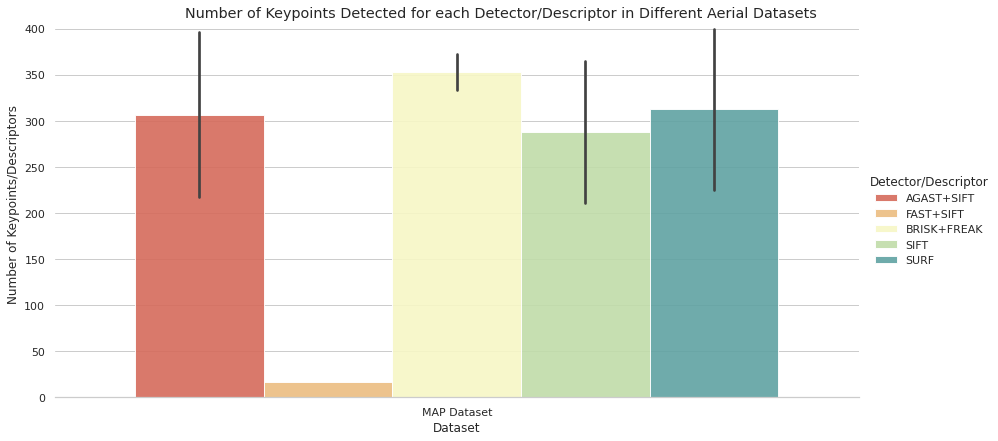

In [59]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_numkey_5, kind="bar",
    x="Dataset", y="Number of Keypoints", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Keypoints/Descriptors")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Kypoints_7_{Dataset}.png')

In [60]:
df_numkey_5.to_csv(f'drive/MyDrive/Num_Kypoints_5_{Dataset}.csv')

In [ ]:
#print(len(num_matches_agast))

Total Number of Matches Detected for each Detector+Descriptor

In [61]:
#df_match_15['Number of Total Matches'] =  num_matches_agast + num_matches_akaze + num_matches_brisk + num_matches_daisy + num_matches_fast + num_matches_freak + num_matches_gftt + num_matches_kaze + num_matches_mser + num_matches_orb + num_matches_rootsift + num_matches_sift + num_matches_briefstar + num_matches_superpoint+ num_matches_surf+ num_matches_surfsift
d = {'Dataset': [f'{Dataset}']*(num_detectors*(len_files-1)), 'Number of Total Matches': num_matches_sift + num_matches_surf + num_matches_freak + num_matches_agast + num_matches_fast, 'Detector/Descriptor': ['AGAST+SIFT']*(len_files-1) + ['SIFT']*(len_files-1) + ['BRISK+FREAK']*(len_files-1) + ['FAST+SIFT']*(len_files-1) + ['SURF']*(len_files-1)}
df_match_5 = pd.DataFrame(data=d)
df_match_5['Number of Total Matches'] = df_match_5['Number of Total Matches']/(len_files-1)

Text(0.5, 0.98, 'Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets')

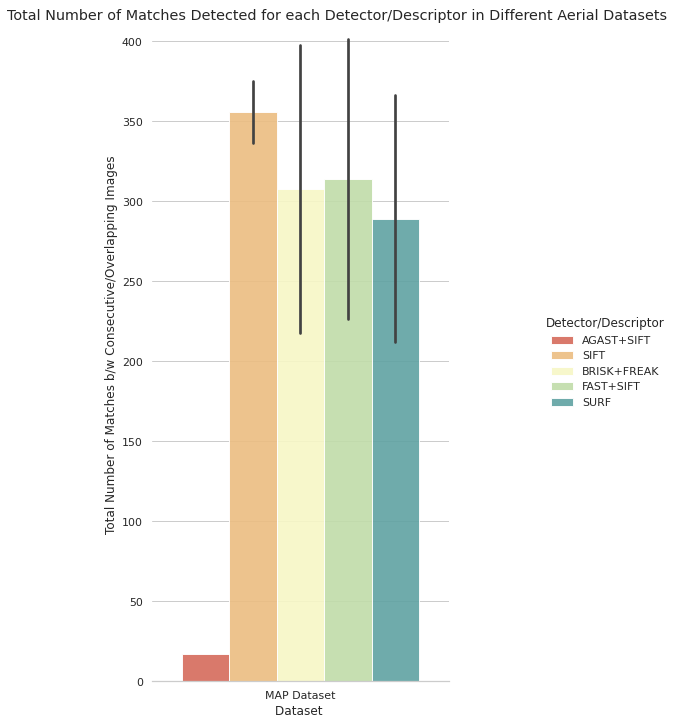

In [62]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="Number of Total Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset ", "Total Number of Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Matches_7_{Dataset}.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Matches_16.csv')

Total Number of Good/Robust Matches (NN+Lowe+RANSAC) Detected for each Detector+Descriptor

In [63]:
df_match_5['Number of Good Matches'] = num_good_matches_agast + num_good_matches_fast + num_good_matches_freak + num_good_matches_surf + num_good_matches_sift
df_match_5['Number of Good Matches'] = df_match_5['Number of Good Matches']/(len_files-1)

Text(0.5, 0.98, 'Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets')

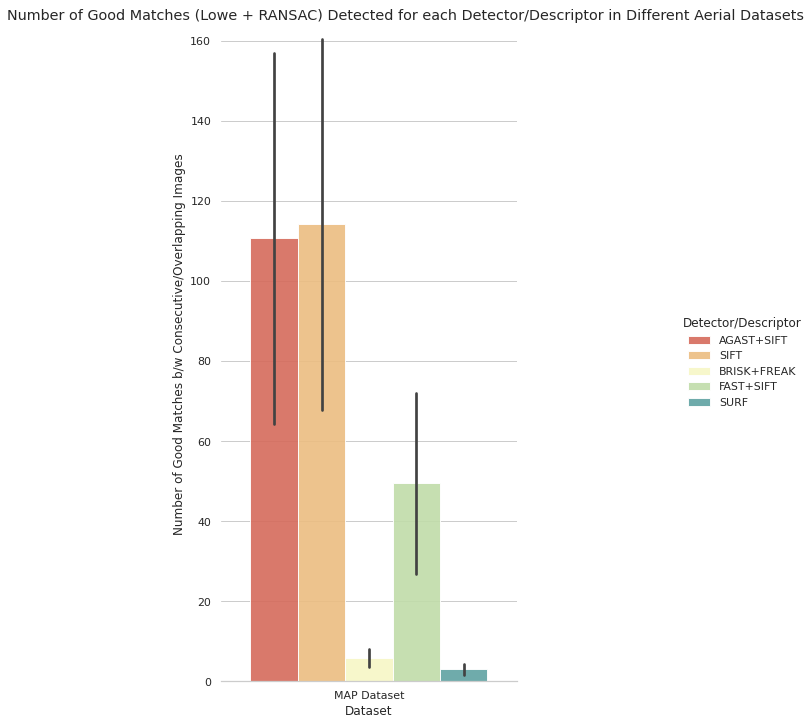

In [64]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="Number of Good Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Good Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig('drive/MyDrive/Num_Good_Matches_7.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Good_Matches_16.csv')

Recall Rate for each Detector+Descriptor

In [65]:
df_match_5['Recall Rate of Matches'] = df_match_5['Number of Good Matches']/df_match_5['Number of Total Matches']

Text(0.5, 0.98, 'Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

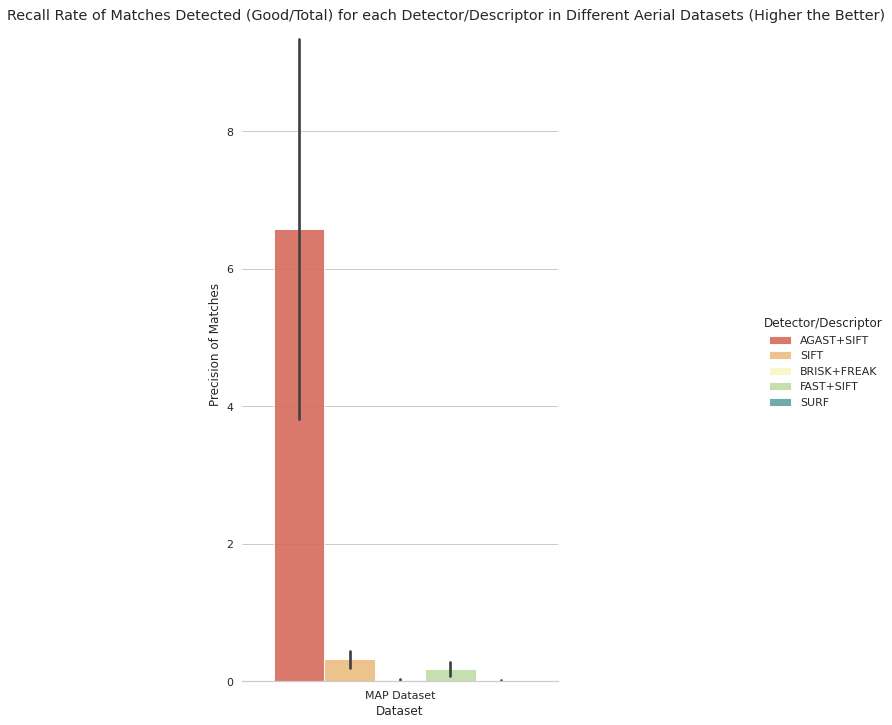

In [66]:
import seaborn as sns
sns.set_theme(style='whitegrid')


g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="Recall Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Precision of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/Recall_Rate_Matches_7.png')

1-Precision Rate for each Detector+Descriptor

In [67]:
df_match_5['1 - Precision Rate of Matches'] = (df_match_5['Number of Total Matches'] - df_match_5['Number of Good Matches'])/df_match_5['Number of Total Matches']

Text(0.5, 0.98, '1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

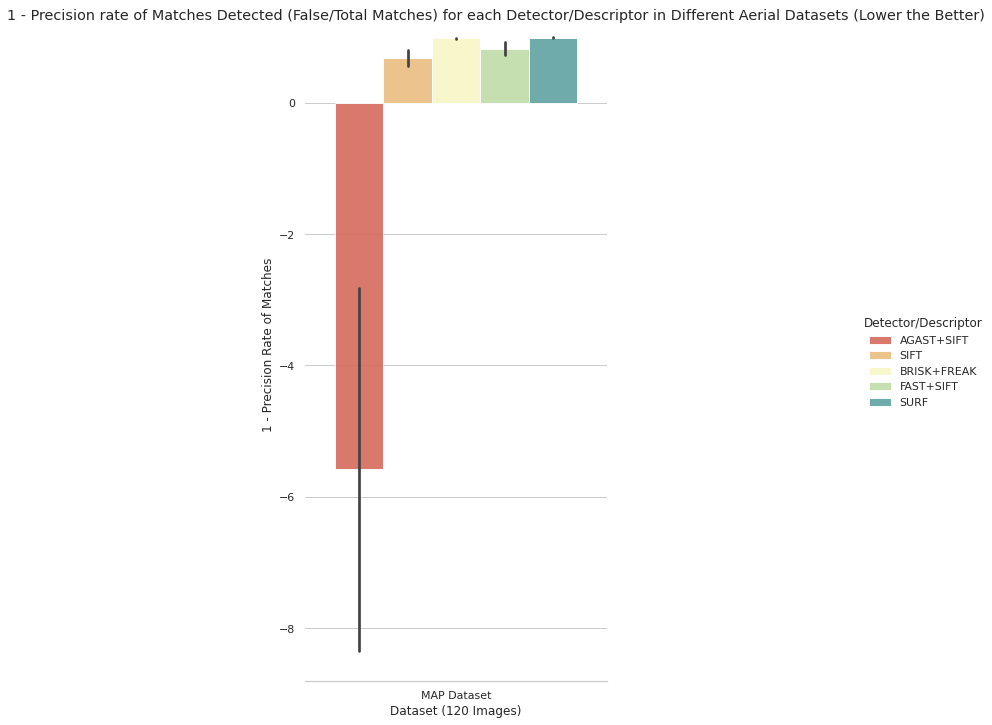

In [68]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="1 - Precision Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset (120 Images)", "1 - Precision Rate of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/One_minus_Precision_Rate_Matches_7.png')

F-Score for each Detector+Descriptor

In [69]:
df_match_5['F-Score'] = (2* (1 - df_match_5['1 - Precision Rate of Matches']) * df_match_5['Recall Rate of Matches'])/((1 - df_match_5['1 - Precision Rate of Matches']) + df_match_5['Recall Rate of Matches'])

Text(0.5, 0.98, 'F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

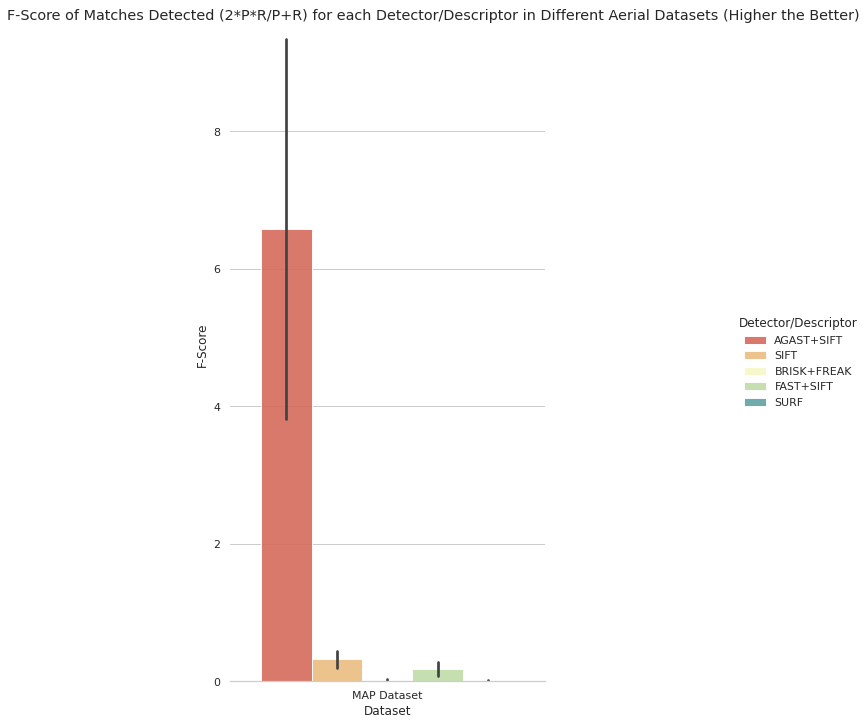

In [70]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_5, kind="bar",
    x="Dataset", y="F-Score", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "F-Score")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/F_Score_Rate_Matches_7.png')

In [71]:
df_match_5.to_csv('drive/MyDrive/All_metrics_5.csv')

Time for each Detector+Descriptor

In [72]:
d = {'Dataset': [f'{Dataset}']*(num_detectors), 'Time': [time_all[3]] + [time_all[0]] + [time_all[2]] + [time_all[1]] + [time_all[4]], 'Detector/Descriptor': ['AGAST+SIFT'] + ['FAST+SIFT']*(1) + ['BRISK+FREAK']*(1) + ['SURF']*(1) +  ['SIFT']*(1) }
df_time_5 = pd.DataFrame(data=d)

In [73]:
print(df_time_5)

       Dataset        Time Detector/Descriptor
0  MAP Dataset  188.262222          AGAST+SIFT
1  MAP Dataset  135.291474           FAST+SIFT
2  MAP Dataset  355.988761         BRISK+FREAK
3  MAP Dataset  391.185377                SURF
4  MAP Dataset  280.952517                SIFT


Text(0.5, 0.98, 'Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

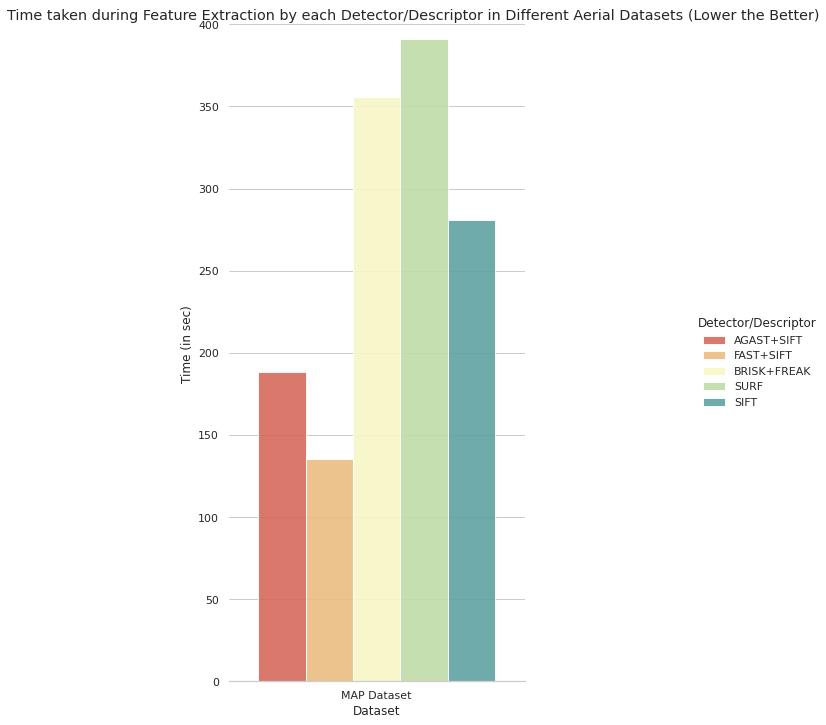

In [74]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_time_5, kind="bar",
    x="Dataset", y="Time", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Time (in sec)")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/Time_7.png')

In [75]:
df_time_5.to_csv('drive/MyDrive/Time_5.csv')

Stitching with CPU